In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dask.array as da

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [2]:
os.chdir('/w2-data2/willytsai/python_module/')
import SCAI_calc4obj as scai 

In [3]:
def subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y%m%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(nlat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                            nlon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[5:16],'%Y%m%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],dim='time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [4]:
def subset_MERRA2(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y%m%d')
        file = sorted(glob('*'+date_str+'*'))[0]
        data = xr.open_dataset(file)
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
        
        if n == 0: 
            tmp = data; n+=1
        else:
            tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [5]:
def subset_gridsat(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc)
                            ,lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[11:24],'%Y.%m.%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [6]:
def SCAI_index(prec_sm,bt_sm):

    N_psT = np.zeros(bt_sm.shape[0]) # BT_based
    N_prec = np.zeros(prec_sm.shape[0]) # prec_based
    SCAI_BT = np.zeros(bt_sm.shape[0]) # cldfrac over domain by BT criteria
    SCAI_p = np.zeros(prec_sm.shape[0]) # cldfrac over domain by prec criteria
    
   # N and SCAI indices
    for t in range(bt_sm.shape[0]):
        label_obj, N = scai.labeled_obj(bt_sm[t,:,:].values,cri=240,flag=2) # less than 240 W/m^2
        SCAI_BT[t] = scai.SCAI_calc(label_obj,N,dx=0.25*100000,L=10*100000)
        N_psT[t] = N
    
    for t in range(prec_sm.shape[0]):
        label_obj, N = scai.labeled_obj(prec_sm[t,:,:].values,cri=1,flag=1) # larger than 1mm/day
        SCAI_p[t] = scai.SCAI_calc(label_obj,N,dx=0.25*100000,L=10*100000)    
        N_prec[t] = N

    return (SCAI_BT,SCAI_p,N_psT,N_prec)

In [7]:
warnings.filterwarnings('ignore')

In [8]:
ISCCP_dir = '/w2-data/willytsai/ISCCP/hgg/'
TRMM_dir = '/w2-data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/w2-data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/w2-data/willytsai/'
ERA5_dir = '/w2-data/willytsai/ERA5/'
Gridsat_dir = '/w2-data/willytsai/gridsat_BT/remap_0.25deg/'
fig_dir = '/w2-data/willytsai/ISCCP/fig/'

### Read data_event from written .dat files

In [9]:
# load data
os.chdir('/w2-data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg.dat'))

In [10]:
os.chdir('/w2-data/willytsai/TQUV_3hr/')
files = glob('*.nc')
lev = xr.open_dataset(files[0]).T.lev # MERRA2 standard level 
del files
os.chdir('/w2-data/willytsai/Cloudfrac_3hr/')
lev_m = np.loadtxt('model_lev.txt')[:,1]# MERRA2 model level, 58 levs [72-15]

In [11]:
def event_region(lat_event,lon_event,lon_w,lon_e,lat_s,lat_n):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event <= lon_e))[0]
    idy = np.where(np.logical_and(lat_event >= lat_s, lat_event <= lat_n))[0]
    idc = np.intersect1d(idx,idy)
    return idc

In [12]:
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

In [13]:
time_event = np.asarray(time_event)
lat_event = lat_event
lon_event = lon_event

In [14]:
os.chdir('/w2-data/willytsai/ISCCP')
T_all = np.load('T_all_5deg.mat.npy')
q_all = np.load('q_all_5deg.mat.npy')
u_all = np.load('u_all_5deg.mat.npy')
v_all = np.load('v_all_5deg.mat.npy')
N_all = np.load('N_all_5deg.mat.npy')
SCAIbt_all = np.load('SCAIbt_all_5deg.mat.npy')
bt_all = np.load('bt_all_5deg.mat.npy')
llws_all = np.load('llws_all_5deg.mat.npy')
prec_all = np.load('prec_all_5deg.mat.npy')
cwv_all = np.load('cwv_all_5deg.mat.npy')
crh_all = np.load('crh_all_5deg.mat.npy')

omega_all = np.load('omega_all_5deg.mat.npy')
rh_all = np.load('rh_all_5deg.mat.npy')
#cwvstd_all = np.load('cwvstd_all.mat.npy')
#SF_all = np.load('SF_all.mat.npy')
cldfrac_all = np.load('cldfrac_all_5deg.mat.npy')
#CFv_all = np.load('CFv_all.mat.npy')
div_all  = np.load('div_all_5deg.mat.npy')
# cwvten_dyn_all = np.load('cwvten_dyn_all_5deg.mat.npy')
# cwvten_phy_all = np.load('cwvten_phy_all_5deg.mat.npy')
# cwvten_ana_all = np.load('cwvten_ana_all_5deg.mat.npy')
#cwvten_tot_all = cwvten_dyn_all+cwvten_phy_all+cwvten_ana_all
Abar_all = (cldfrac_all/N_all*2500*(10*10))**0.5 # square root of Area [km]
#cape_all = np.load('cape_all.mat.npy')
#cin_all = np.load('cin_all.mat.npy')

cldamt_cu_all = np.load('cldamt_cu_all_5deg.mat.npy')
cldamt_st_all = np.load('cldamt_st_all_5deg.mat.npy')
cldamt_dc_all = np.load('cldamt_dc_all_5deg.mat.npy')

LHF_all = np.load('LHF_all_5deg.mat.npy')
SHF_all = np.load('SHF_all_5deg.mat.npy')
qvflux_all = np.load('qvfluxm_all_5deg.mat.npy')

ctp_all = np.load('ctpir_all_5deg.mat.npy')
precM2_all = np.load('precM2_all_5deg.mat.npy')
# TQL_all = np.load('TQL_all.mat_5deg.npy')
# TQI_all = np.load('TQI_all.mat_5deg.npy')
# TQLI_all = TQL_all + TQI_all; del TQL_all, TQI_all

In [15]:
def center_case(time_event,lon_event,lat_event,cri_r=300,ratio=0.5):
    'precipitation area is enclosed within a circle R at reference time'
    
    file_path = TRMM_dir+'2014_2018'
    time_cent = time_event
    lat_cent = lat_event
    lon_cent = lon_event
    
    # read preciptation data in the given domain
    data = subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=0,lat_inc=2.5,lon_inc=2.5)
    prec_sm = data.precipitation.squeeze()
    prec_sum = np.nansum(prec_sm)

    # calculate the distance matrix
    x,y = np.meshgrid(prec_sm.nlon,prec_sm.nlat)
    dist = np.sqrt((x-lon_cent)**2+(y-lat_cent)**2)*100 # distance from center [km]
    prec_sm.values[dist > cri_r] = 0
    prec_frac = (np.nansum(prec_sm)/prec_sum)
    
    if prec_frac >= ratio:
        result = 1
    else:
        result = 0

    return result

In [16]:
def remove_diurnal_1D(data_all):
    'remove diurnal cycle in the time series [N,time], N cases'
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        tmp = np.fft.fft(data_all[n,:]) # 49
        freqs = np.array(range(NT))   # This gets the left end correct
        reversed_freqs = freqs[::-1]  # Reverse the array 
        reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
        freqs = reversed_freqs[::-1]  # reverse it back 
        tmp[np.where(freqs==6)] = 0 # remove diurnal 6 cycles for 6 days
        tmp[np.where(freqs==12)] = 0 # remove half-day
        tmp[np.where(freqs==11)] = 0
        tmp_re[n,:] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

In [17]:
def remove_diurnal_2D(data_all):
    'remove diurnal cycle in the time series [N,time,lev], N cases'
    
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        for k in range(data_all.shape[2]):
            tmp = np.fft.fft(data_all[n,:,k]) # 49
            freqs = np.array(range(NT))   # This gets the left end correct
            reversed_freqs = freqs[::-1]  # Reverse the array 
            reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
            freqs = reversed_freqs[::-1]  # reverse it back 
            tmp[np.where(freqs==6)] = 0 # remove diurnal 6 cycles for 6 days
            tmp[np.where(freqs==12)] = 0 # remove half-day
            tmp[np.where(freqs==11)] = 0
            tmp_re[n,:,k] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

#### overlapping events identification and removal

In [18]:
lat_cen = np.arange(-7.5,10,2.5)
lon_cen = np.arange(-177.5,180,2.5)
idx_record = [] # idx list for final events

for lat in lat_cen:
    for lon in lon_cen:
        idx = np.where(lat_event==lat)[0]
        idy = np.where(lon_event==lon)[0]
        idx_org = np.intersect1d(idx,idy)
        
        time_frame = time_event[idx_org]
        for i,idx in enumerate(idx_org):
            if i == 0:
                if (time_frame[i+1]-time_frame[i]).days >= 6:
                    idx_record.append(idx)
            elif i == len(idx_org)-1:
                if (time_frame[i]-time_frame[i-1]).days >= 6:
                    idx_record.append(idx)
            else:
                if (time_frame[i+1]-time_frame[i]).days >= 6 and \
                   (time_frame[i]-time_frame[i-1]).days >= 6:
                    idx_record.append(idx)            

In [19]:
idx_rm = np.array(idx_record) # new idx with removal overlapping

In [20]:
time_event = time_event[idx_rm]
lat_event = lat_event[idx_rm]
lon_event = lon_event[idx_rm]

T_all = T_all[idx_rm,:,:]
q_all = q_all[idx_rm,:,:]
u_all = u_all[idx_rm,:,:]
v_all = v_all[idx_rm,:,:]
N_all = N_all[idx_rm,:]
SCAIbt_all = SCAIbt_all[idx_rm,:]
bt_all = bt_all[idx_rm,:]
#llws_all = llws_all[idx_rm,:]
prec_all = prec_all[idx_rm,:]
#precstd_all = precstd_all[idx_rm,:]
cwv_all = cwv_all[idx_rm,:]
crh_all = crh_all[idx_rm,:]

omega_all = omega_all[idx_rm,:,:]
rh_all = rh_all[idx_rm,:,:]
#cwvstd_all = cwvstd_all[idx_rm,:]

cldfrac_all = cldfrac_all[idx_rm,:]
#CFv_all = CFv_all[idx_rm,:,:]
div_all  = div_all[idx_rm,:,:]
# cwvten_dyn_all = cwvten_dyn_all[idx_rm,:]
# cwvten_phy_all = cwvten_phy_all[idx_rm,:]
# cwvten_ana_all = cwvten_ana_all[idx_rm,:]
#cwvten_tot_all = cwvten_dyn_all+cwvten_phy_all+cwvten_ana_all
Abar_all = Abar_all[idx_rm,:]
#cape_all = cape_all[idx_rm,:]
#cin_all = cin_all[idx_rm,:]

cldamt_cu_all = cldamt_cu_all[idx_rm,:]
cldamt_st_all = cldamt_st_all[idx_rm,:]
cldamt_dc_all = cldamt_dc_all[idx_rm,:]

qvflux_all = qvflux_all[idx_rm,:,:]
SHF_all = SHF_all[idx_rm,:]
LHF_all = LHF_all[idx_rm,:]
ctp_all = ctp_all[idx_rm,:]
#precM2_all = precM2_all[idx_rm,:]
#TQLI_all = TQLI_all[idx_rm,:]

In [21]:
# remove diurnal cycle and marginal cases
T_all = remove_diurnal_2D(T_all) 
q_all = remove_diurnal_2D(q_all)
u_all = remove_diurnal_2D(u_all)
v_all = remove_diurnal_2D(v_all)
N_all = N_all
SCAIbt_all = SCAIbt_all
llws_all = remove_diurnal_1D(llws_all)
bt_all = remove_diurnal_1D(bt_all)
prec_all = prec_all
#precstd_all = remove_diurnal_1D(prec_all)
cwv_all = remove_diurnal_1D(cwv_all)
crh_all = remove_diurnal_1D(crh_all)

omega_all = remove_diurnal_2D(omega_all)
rh_all = remove_diurnal_2D(rh_all)
#cwvstd_all = remove_diurnal_1D(cwvstd_all)
#SF_all = remove_diurnal_1D(SF_all)
cldfrac_all = cldfrac_all
#CFv_all = remove_diurnal_2D(CFv_all)
div_all  = remove_diurnal_2D(div_all); 
#cwvten_dyn_all = remove_diurnal_1D(cwvten_dyn_all)
#cwvten_phy_all = remove_diurnal_1D(cwvten_phy_all)
#cwvten_ana_all = remove_diurnal_1D(cwvten_ana_all)
#cwvten_tot_all = cwvten_dyn_all+cwvten_phy_all+cwvten_ana_all;
Abar_all = Abar_all
#cape_all = remove_diurnal_1D(cape_all)
#cin_all = remove_diurnal_1D(cin_all)

# crh_q1_all = remove_diurnal_1D(crh_q1_all)
# crh_q4_all = remove_diurnal_1D(crh_q4_all)

# cwv_q1_all = remove_diurnal_1D(cwv_q1_all)
# cwv_q4_all = remove_diurnal_1D(cwv_q4_all)

# rh_q1_all = remove_diurnal_2D(rh_q1_all)
# rh_q4_all = remove_diurnal_2D(rh_q4_all)

cldamt_cu_all = cldamt_cu_all
cldamt_st_all = cldamt_st_all
cldamt_dc_all = cldamt_dc_all

SHF_all = remove_diurnal_1D(SHF_all)
LHF_all = remove_diurnal_1D(LHF_all)
SFX_all = SHF_all + LHF_all
#TQLI_all = remove_diurnal_1D(TQLI_all)

#SFXstd_all = remove_diurnal_1D(SFXstd_all)
qvflux_all = remove_diurnal_2D(qvflux_all)
ctp_all = ctp_all
precM2_all = precM2_all
#qvflux_all = qvflux_all

In [22]:
# deal with qvflux at the first level
for n in range(len(time_event)):
    for t in range(49):
        if np.isnan(qvflux_all[n,t,0]) == True:
            qvflux_all[n,t,0] = qvflux_all[n,t,1]

In [23]:
# remove wrong values
idx = np.where(np.logical_or(cldamt_cu_all>100,cldamt_cu_all<0))
cldamt_cu_all[idx] = np.nan
idx = np.where(np.logical_or(cldamt_st_all>100,cldamt_st_all<0))
cldamt_st_all[idx] = np.nan
idx = np.where(np.logical_or(cldamt_dc_all>100,cldamt_dc_all<0))
cldamt_dc_all[idx] = np.nan

In [24]:
def idx_season(time_event):
    "return idx for four seasons"
    idx_DJF = [];idx_MAM = []
    idx_JJA = [];idx_SON = []
    for i,time in enumerate(time_event):
        if time.month == 12 or time.month == 1 or time.month == 2:
            idx_DJF.append(i)
        if time.month == 3 or time.month == 4 or time.month == 5:
            idx_MAM.append(i)
        if time.month == 6 or time.month == 7 or time.month == 8:
            idx_JJA.append(i)
        if time.month == 9 or time.month == 10 or time.month == 11:
            idx_SON.append(i)
    
    return idx_DJF,idx_MAM,idx_JJA,idx_SON

#### TRMM precipitation seasonality showcases

In [9]:
os.chdir(TRMM_dir+'2014_2018')

In [10]:
%%time
date = []; date_begin = datetime(2014,1,1)
for t in range(14608):
    tmp = date_begin + t*timedelta(hours=3)
    date.append(tmp)
                
# # TRMM3B42 dataset 2014, 3hrly separate
prec_3hr = np.nan*np.zeros((len(date),241,1440))

CPU times: user 1.9 s, sys: 1min 53s, total: 1min 55s
Wall time: 2min 50s


In [ ]:
%%time
files = sorted(glob('3B42.*'))
for n,file in enumerate(files):
    try:
        data = xr.open_dataset(file).precipitation        
        prec_3hr[n,:,:] = data.values.swapaxes(0,1)
    except:
        prec_3hr[n,:,:] = np.nan       
lon = data.nlon; lat = data.nlat
prec_xr = xr.DataArray(prec_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del prec_3hr

In [ ]:
# # explanation rate 
lon_bin = np.arange(-175,185,5)
lat_bin = np.arange(-5,10,5)

precsum_total = np.zeros((len(lon_bin),len(lat_bin)))
for i,lon_cen in enumerate(lon_bin):
    for j,lat_cen in enumerate(lat_bin):
        precsum_total[i,j] = prec_xr.sel(lat=slice(lat_cen-5,lat_cen+5),lon=slice(lon_cen-5,lon_cen+5)).sum()

In [31]:
precsum_event = np.copy(precsum_total)*0
for n in range(len(time_event)):
    
    for i,lon_cen in enumerate(lon_bin):
        for j,lat_cen in enumerate(lat_bin):
            if lon_cen == lon_event[n] and lat_cen == lat_event[n]:
                precsum_event[i,j] += prec_all[n,:].sum()*1600 

In [32]:
# convert lon_bin, lat_bin for pcolormap
lat_edge = np.arange(-7.5,12.5,5)
lon_edge = np.arange(-182.5,182.5,5)

cover_ratio = precsum_event/precsum_total # explained total rainfall

cover_ratio = np.vstack([np.zeros((cover_ratio.shape[1])),cover_ratio])
cover_ratio = np.vstack([cover_ratio.T,np.zeros((cover_ratio.shape[0])).T]).T
cover_ratio[cover_ratio==0] = np.nan

In [33]:
# fig = plt.figure(figsize=(13,4))
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# clevs=np.linspace(0,20,21)
# ps = plt.pcolormesh(lon_edge,lat_edge,cover_ratio.T,transform=ccrs.PlateCarree(),
#                   cmap='jet',)
# cbar = plt.colorbar(fraction=0.05,pad=0.1,orientation='horizontal')
# cbar.set_label('[mm/day]',fontsize=12)
# #cs = plt.contour(prec_clim.lon,prec_clim.lat,prec_clim.mean(axis=0)*24)
# ax.coastlines()
# ax.add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='whitesmoke') # maskout LAND
# #gl = ax.gridlines(draw_labels=False,linestyle='--')
# #gl.xlabels_top = gl.ylabels_right = False
# #gl.xformatter = LONGITUDE_FORMATTER
# #gl.yformatter = LATITUDE_FORMATTER

# ax.set_yticks([-20,-15,-10,-5,0,5,10,15,20])
# ax.set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
# ax.set_xticks([-179.875,-120,-60,-0,60,120,179.875])
# ax.set_xticklabels(['0','60E','120E','180','120W','60W','0'])
# ax.set_ylim([-20,20]);ax.grid(linestyle=':')

#### Region definition

In [34]:
idx_IND = event_region(lat_event,lon_event,60,90,-10,10) # Tropical Indian Ocean
idx_WPC = event_region(lat_event,lon_event,150,180,-10,10) # Tropical Western Pacific
idx_EPC = event_region(lat_event,lon_event,-180,-90,-10,10) # Tropical Eastern Pacific

In [35]:
len(idx_IND)+len(idx_WPC)+len(idx_EPC)

27042

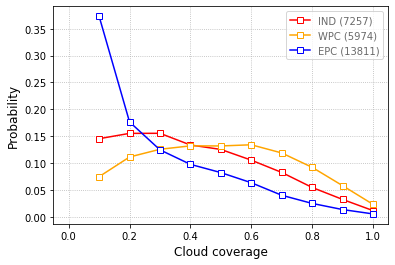

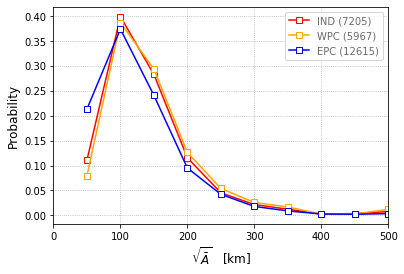

In [36]:
cldfrac_IND = cldfrac_all[idx_IND,:] # reference cloud coverage 
cldfrac_WPC = cldfrac_all[idx_WPC,:] # reference cloud coverage 
cldfrac_EPC = cldfrac_all[idx_EPC,:] # reference cloud coverage 

prec_IND = prec_all[idx_IND,:] 
prec_WPC = prec_all[idx_WPC,:] 
prec_EPC = prec_all[idx_EPC,:] 

crh_IND = crh_all[idx_IND,:] 
crh_WPC = crh_all[idx_WPC,:] 
crh_EPC = crh_all[idx_EPC,:] 

Abar_IND = Abar_all[idx_IND,:]
Abar_WPC = Abar_all[idx_WPC,:]
Abar_EPC = Abar_all[idx_EPC,:]

SCAIbt_IND = SCAIbt_all[idx_IND,:]
SCAIbt_WPC = SCAIbt_all[idx_WPC,:]
SCAIbt_EPC = SCAIbt_all[idx_EPC,:]

N_IND = N_all[idx_IND,:]
N_WPC = N_all[idx_WPC,:]
N_EPC = N_all[idx_EPC,:]

q_IND = q_all[idx_IND,:,:]
q_WPC = q_all[idx_WPC,:,:]
q_EPC = q_all[idx_EPC,:,:]

buoy_IND = buoy_all[idx_IND,:,:]
buoy_WPC = buoy_all[idx_WPC,:,:]
buoy_EPC = buoy_all[idx_EPC,:,:]

rh_IND = rh_all[idx_IND,:,:]
rh_WPC = rh_all[idx_WPC,:,:]
rh_EPC = rh_all[idx_EPC,:,:]

#------------------------------------------------
counts_IND,bins = np.histogram(cldfrac_IND[:,24],bins=10,range=(0,1))
plt.plot(bins[1:],counts_IND/sum(counts_IND),'-sr',markerfacecolor='w')
counts_WPC,bins = np.histogram(cldfrac_WPC[:,24],bins=10,range=(0,1))
plt.plot(bins[1:],counts_WPC/sum(counts_WPC),'-s',color='orange',markerfacecolor='w')
counts_EPC,bins = np.histogram(cldfrac_EPC[:,24],bins=10,range=(0,1))
plt.plot(bins[1:],counts_EPC/sum(counts_EPC),'-sb',markerfacecolor='w')
plt.ylabel('Probability',fontsize=12);plt.xlabel('Cloud coverage',fontsize=12)
legend=plt.legend(['IND '+'('+str(sum(counts_IND))+')',
            'WPC '+'('+str(sum(counts_WPC))+')',
            'EPC '+'('+str(sum(counts_EPC))+')'])
plt.setp(legend.get_texts(),color='dimgrey')
plt.xlim([-0.05,1.05]);plt.grid(linestyle=':');plt.show()

counts_IND,bins = np.histogram(Abar_IND[:,24],bins=10,range=(0,500))
plt.plot(bins[1:],counts_IND/sum(counts_IND),'-sr',markerfacecolor='w')
counts_WPC,bins = np.histogram(Abar_WPC[:,24],bins=10,range=(0,500))
plt.plot(bins[1:],counts_WPC/sum(counts_WPC),'-s',color='orange',markerfacecolor='w')
counts_EPC,bins = np.histogram(Abar_EPC[:,24],bins=10,range=(0,500))
plt.plot(bins[1:],counts_EPC/sum(counts_EPC),'-sb',markerfacecolor='w')
plt.ylabel('Probability',fontsize=12);plt.xlabel(r'$\sqrt{\bar{A}}$   [km]',fontsize=12)
legend=plt.legend(['IND '+'('+str(sum(counts_IND))+')',
            'WPC '+'('+str(sum(counts_WPC))+')',
            'EPC '+'('+str(sum(counts_EPC))+')'])
plt.setp(legend.get_texts(),color='dimgrey')
plt.xlim([0,500]);plt.grid(linestyle=':');plt.show()

In [37]:
# # CRH vs cloud cover for all regimes
# crh_cri = np.array([0,0.5,0.65,0.8,1])
# cover_cri = np.array([0,0.2,0.4,0.6,0.8,1])
# cover_bin = np.zeros((len(crh_cri)-1,len(cover_cri)-1))
# precm_bin = np.copy(cover_bin)
# precste_bin = np.copy(cover_bin)
# SCAIbt_bin = np.copy(cover_bin)
# SCAIbtste_bin = np.copy(cover_bin)

# for n in range(len(crh_cri)-1):
#     idx = np.where(np.logical_and(crh_all[:,24]>=crh_cri[n],crh_all[:,24]<crh_cri[n+1]))[0]
    
#     cover_tmp = cldfrac_all[idx,:]
#     prec_tmp = prec_all[idx,:]
#     Abar_tmp = Abar_all[idx,:]
#     SCAIbt_tmp = SCAIbt_all[idx,:]
    
#     for i in range(len(cover_cri)-1):
#         idx2 = np.where(np.logical_and(cover_tmp[:,24]>=cover_cri[i]
#                                       ,cover_tmp[:,24]<cover_cri[i+1]))[0]
#         cover_bin[n,i] = len(idx2)
#         precm_bin[n,i] = np.nanmean(prec_tmp[idx2,24])
#         precste_bin[n,i] = np.nanstd(prec_tmp[idx2,24])/(len(idx2)**0.5)
#         SCAIbt_bin[n,i] = np.nanmean(SCAIbt_tmp[idx2,24])
#         SCAIbtste_bin[n,i] = np.nanstd(SCAIbt_tmp[idx2,24])/(len(idx2)**0.5)
        

In [38]:
# fig, ax = plt.subplots(1,4,figsize=(14,3.5))

# ax[0].bar(['0','0.2','0.4','0.6','0.8'],cover_bin[0,:]/sum(cover_bin[0,:]),width=0.6,alpha=0.5)
# ax[0].set_xticks([-0.5,0.5,1.5,2.5,3.5]);ax[0].set_xticklabels(['0','0.2','0.4','0.6','0.8'])
# ax[0].set_xlabel('Cloud cover',fontsize=12);ax[0].set_ylabel('Probability',fontsize=12)
# ax[0].set_title('CRH_ref: 0-0.5, All',fontsize=12)
# ax[0].grid(axis='y',linestyle=':');ax[0].text(x=3.5,y=0.90,s=str(int(sum(cover_bin[0,:]))),color='grey')
# ax[0].set_ylim([0,1])

# ax[1].bar(['0','0.2','0.4','0.6','0.8'],cover_bin[1,:]/sum(cover_bin[1,:]),width=0.6,alpha=0.5)
# ax[1].set_xticks([-0.5,0.5,1.5,2.5,3.5]);ax[1].set_xticklabels(['0','0.2','0.4','0.6','0.8'])
# ax[1].set_xlabel('Cloud cover',fontsize=12);ax[1].set_ylabel('Probability',fontsize=12)
# ax[1].set_title('CRH_ref: 0.5-0.65, All',fontsize=12)
# ax[1].grid(axis='y',linestyle=':');ax[1].text(x=3.5,y=0.63,s=str(int(sum(cover_bin[1,:]))),color='grey')
# ax[1].set_ylim([0,0.7])

# ax[2].bar(['0','0.2','0.4','0.6','0.8'],cover_bin[2,:]/sum(cover_bin[2,:]),width=0.6,alpha=0.5)
# ax[2].set_xticks([-0.5,0.5,1.5,2.5,3.5]);ax[2].set_xticklabels(['0','0.2','0.4','0.6','0.8'])
# ax[2].set_xlabel('Cloud cover',fontsize=12);ax[2].set_ylabel('Probability',fontsize=12)
# ax[2].set_title('CRH_ref: 0.65-0.8, All',fontsize=12)
# ax[2].grid(axis='y',linestyle=':');ax[2].text(x=3.5,y=0.63,s=str(int(sum(cover_bin[2,:]))),color='grey')
# ax[2].set_ylim([0,0.7])

# ax[3].bar(['0','0.2','0.4','0.6','0.8'],cover_bin[3,:]/sum(cover_bin[3,:]),width=0.6,alpha=0.5)
# ax[3].set_xticks([-0.5,0.5,1.5,2.5,3.5]);ax[3].set_xticklabels(['0','0.2','0.4','0.6','0.8'])
# ax[3].set_xlabel('Cloud cover',fontsize=12);ax[3].set_ylabel('Probability',fontsize=12)
# ax[3].set_title('CRH_ref: 0.8-1, All',fontsize=12)
# ax[3].grid(axis='y',linestyle=':');ax[3].text(x=3.5,y=0.63,s=str(int(sum(cover_bin[3,:]))),color='grey')
# ax[3].set_ylim([0,0.7])

# # adding precipitation_mean variations in each subplot
# ax0 = ax[0].twinx()
# #ax0.plot([0,1,2,3,4],precm_bin[0,:]*24,'xr');ax0.set_ylim([5,80])
# ax0.errorbar([0,1,2,3,4],SCAIbt_bin[0,:],yerr=SCAIbtste_bin[0,:],fmt='or');ax0.set_ylim([0,15])
# ax0.tick_params(axis='y', labelcolor='r');ax0.set_ylabel('SCAI',color='r')

# ax1 = ax[1].twinx()
# #ax1.plot([0,1,2,3,4],precm_bin[1,:]*24,'xr');ax1.set_ylim([5,80])
# ax1.errorbar([0,1,2,3,4],SCAIbt_bin[1,:],yerr=SCAIbtste_bin[1,:],fmt='or');ax1.set_ylim([0,15])
# ax1.tick_params(axis='y', labelcolor='r');ax1.set_ylabel('SCAI',color='r')

# ax2 = ax[2].twinx()
# #ax2.plot([0,1,2,3,4],precm_bin[2,:]*24,'xr');ax2.set_ylim([5,80])
# ax2.errorbar([0,1,2,3,4],SCAIbt_bin[2,:],yerr=SCAIbtste_bin[2,:],fmt='or');ax2.set_ylim([0,15])
# ax2.tick_params(axis='y', labelcolor='r');ax2.set_ylabel('SCAI',color='r')

# ax3 = ax[3].twinx()
# #ax3.plot([0,1,2,3,4],precm_bin[3,:]*24,'xr');ax3.set_ylim([5,80])
# ax3.errorbar([0,1,2,3,4],SCAIbt_bin[3,:],yerr=SCAIbtste_bin[3,:],fmt='or');ax3.set_ylim([0,15])
# ax3.tick_params(axis='y', labelcolor='r');ax3.set_ylabel('SCAI',color='r')

# plt.tight_layout()

# fig.savefig(fig_dir+'CRH_CF_groups_SCAI_All.pdf',dip=200,bbox_inchs='tight')

#### Stats for reference time

In [39]:
# cloud cover & Abar
#cover_cri = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cover_cri = np.linspace(0,1,21)
Abar_bin = np.zeros((3,len(cover_cri)-1))
Abarstd_bin = np.copy(Abar_bin)

for i in range(len(cover_cri)-1):
    idx1 = np.where(np.logical_and(cldfrac_IND[:,24]>=cover_cri[i]
                                 ,cldfrac_IND[:,24]<cover_cri[i+1]))[0]
    idx2 = np.where(np.logical_and(cldfrac_WPC[:,24]>=cover_cri[i]
                                 ,cldfrac_WPC[:,24]<cover_cri[i+1]))[0]
    idx3 = np.where(np.logical_and(cldfrac_EPC[:,24]>=cover_cri[i]
                                 ,cldfrac_EPC[:,24]<cover_cri[i+1]))[0]
    Abar_tmp1 = Abar_IND[idx1,24]
    Abar_tmp1 = Abar_tmp1[~np.isnan(Abar_tmp1)]
    Abar_tmp2 = Abar_WPC[idx2,24]
    Abar_tmp2 = Abar_tmp2[~np.isnan(Abar_tmp2)]    
    Abar_tmp3 = Abar_EPC[idx3,24]
    
    Abar_tmp3 = Abar_tmp3[~np.isnan(Abar_tmp3)]
    
    Abar_bin[0,i] = np.nanmean(Abar_tmp1)
    Abar_bin[1,i] = np.nanmean(Abar_tmp2)
    Abar_bin[2,i] = np.nanmean(Abar_tmp3)
    
    Abarstd_bin[0,i] = np.nanstd(Abar_tmp1)/len(idx1)**0.5
    Abarstd_bin[1,i] = np.nanstd(Abar_tmp2)/len(idx2)**0.5
    Abarstd_bin[2,i] = np.nanstd(Abar_tmp3)/len(idx3)**0.5
    
    #Abarstd_bin[i] = np.nanstd(Abar_all[idx,24])/len(idx)**0.5

In [40]:
# cloud cover & N
#cover_cri = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cover_cri = np.linspace(0,1,21)
N_bin = np.zeros((3,len(cover_cri)-1))
Nstd_bin = np.copy(N_bin)

for i in range(len(cover_cri)-1):
    idx1 = np.where(np.logical_and(cldfrac_IND[:,24]>=cover_cri[i]
                                 ,cldfrac_IND[:,24]<cover_cri[i+1]))[0]
    idx2 = np.where(np.logical_and(cldfrac_WPC[:,24]>=cover_cri[i]
                                 ,cldfrac_WPC[:,24]<cover_cri[i+1]))[0]
    idx3 = np.where(np.logical_and(cldfrac_EPC[:,24]>=cover_cri[i]
                                 ,cldfrac_EPC[:,24]<cover_cri[i+1]))[0]
    N_tmp1 = N_IND[idx1,24]
    N_tmp1 = N_tmp1[~np.isnan(N_tmp1)]
    N_tmp2 = N_WPC[idx2,24]
    N_tmp2 = N_tmp2[~np.isnan(N_tmp2)]    
    N_tmp3 = N_EPC[idx3,24]
    N_tmp3 = N_tmp3[~np.isnan(N_tmp3)]
    
    N_bin[0,i] = np.nanmean(N_tmp1)
    N_bin[1,i] = np.nanmean(N_tmp2)
    N_bin[2,i] = np.nanmean(N_tmp3)
    
    Nstd_bin[0,i] = np.nanstd(N_tmp1)/len(idx1)**0.5
    Nstd_bin[1,i] = np.nanstd(N_tmp2)/len(idx2)**0.5
    Nstd_bin[2,i] = np.nanstd(N_tmp3)/len(idx3)**0.5
    
    #Abarstd_bin[i] = np.nanstd(Abar_all[idx,24])/len(idx)**0.5

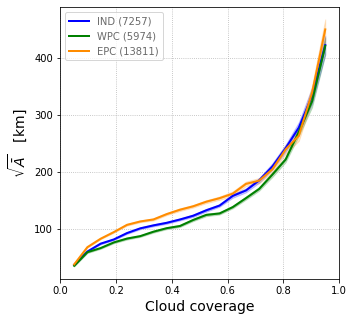

In [41]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.linspace(0.05,0.95,20),Abar_bin[0,:],linewidth=2,color='b')
plt.fill_between(np.linspace(0.05,0.95,20),Abar_bin[0,:]+Abarstd_bin[0,:],Abar_bin[0,:],
                color='b',alpha=0.2)
plt.fill_between(np.linspace(0.05,0.95,20),Abar_bin[0,:]-Abarstd_bin[0,:],Abar_bin[0,:],
                color='b',alpha=0.2)

plt.plot(np.linspace(0.05,0.95,20),Abar_bin[1,:],linewidth=2,color='g')
plt.fill_between(np.linspace(0.05,0.95,20),Abar_bin[1,:]+Abarstd_bin[1,:],Abar_bin[1,:],
                color='g',alpha=0.2)
plt.fill_between(np.linspace(0.05,0.95,20),Abar_bin[1,:]-Abarstd_bin[1,:],Abar_bin[1,:],
                color='g',alpha=0.2)

plt.plot(np.linspace(0.05,0.95,20),Abar_bin[2,:],linewidth=2,color='darkorange')
plt.fill_between(np.linspace(0.05,0.95,20),Abar_bin[2,:]+Abarstd_bin[2,:],Abar_bin[2,:],
                color='darkorange',alpha=0.2)
plt.fill_between(np.linspace(0.05,0.95,20),Abar_bin[2,:]-Abarstd_bin[2,:],Abar_bin[2,:],
                color='darkorange',alpha=0.2)
plt.xlim([0,1])
plt.ylabel(r'$\sqrt{\bar{A}}$   [km]',fontsize=14);plt.xlabel('Cloud coverage',fontsize=14)
legend=plt.legend(['IND '+'('+str(len(idx_IND))+')',
            'WPC '+'('+str(len(idx_WPC))+')',
            'EPC '+'('+str(len(idx_EPC))+')'],loc=2)
plt.setp(legend.get_texts(),color='dimgrey')
plt.grid(linestyle=':');plt.show()
plt.rcParams.update({'font.size': 13})

#fig.savefig(fig_dir+'relation_cloudcover_Abar.pdf',bbox_inches='tight')

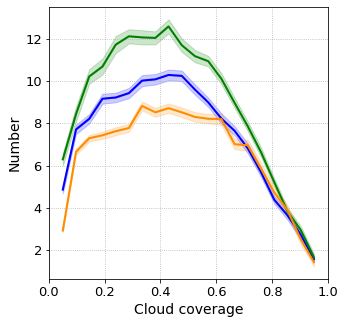

In [42]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.linspace(0.05,0.95,20),N_bin[0,:],linewidth=2,color='b')
plt.fill_between(np.linspace(0.05,0.95,20),N_bin[0,:]+Nstd_bin[0,:],N_bin[0,:],
                color='b',alpha=0.2)
plt.fill_between(np.linspace(0.05,0.95,20),N_bin[0,:]-Nstd_bin[0,:],N_bin[0,:],
                color='b',alpha=0.2)

plt.plot(np.linspace(0.05,0.95,20),N_bin[1,:],linewidth=2,color='g')
plt.fill_between(np.linspace(0.05,0.95,20),N_bin[1,:]+Nstd_bin[1,:],N_bin[1,:],
                color='g',alpha=0.2)
plt.fill_between(np.linspace(0.05,0.95,20),N_bin[1,:]-Nstd_bin[1,:],N_bin[1,:],
                color='g',alpha=0.2)

plt.plot(np.linspace(0.05,0.95,20),N_bin[2,:],linewidth=2,color='darkorange')
plt.fill_between(np.linspace(0.05,0.95,20),N_bin[2,:]+Nstd_bin[2,:],N_bin[2,:],
                color='darkorange',alpha=0.2)
plt.fill_between(np.linspace(0.05,0.95,20),N_bin[2,:]-Nstd_bin[2,:],N_bin[2,:],
                color='darkorange',alpha=0.2)
plt.xlim([0,1])
plt.ylabel('Number',fontsize=14);plt.xlabel('Cloud coverage',fontsize=14)
#plt.legend(['IND','WPC','EPC'],fontsize=12,loc=2)
plt.rcParams.update({'font.size': 13})
plt.grid(linestyle=':');plt.show()

#fig.savefig(fig_dir+'relation_cloudcover_number.pdf',bbox_inches='tight')

In [43]:
# cloud scale distribution
os.chdir('/w2-data/willytsai/ISCCP')
cldscale_dist = np.load('cldscale_dist_all_5deg.mat.npy')
cldscale_dist = cldscale_dist[idx_rm,:]
bins = np.linspace(0,500,21)

In [44]:
cf_bins = np.array([0,0.1,0.2,0.4,0.6,0.8,1])
cldscale_com = np.zeros((len(cf_bins)-1,20))
for n in range(len(cf_bins)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>= cf_bins[n], cldfrac_all[:,24]<cf_bins[n+1]))[0]
    cldscale_com[n,:] = np.sum(cldscale_dist[idx,:],axis=0)

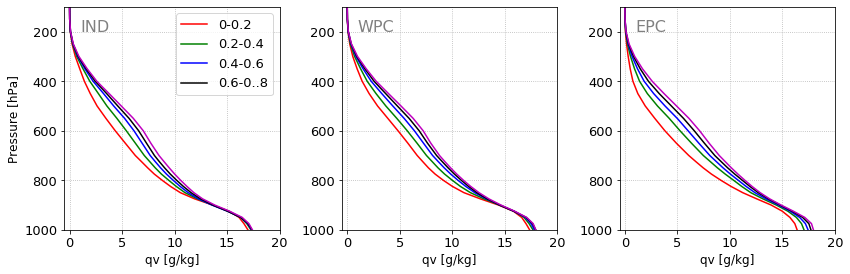

In [45]:
# qv, rh profile binned by cloud coverage
cover_cri = np.array([0,0.2,0.4,0.6,0.8,1])
qv_binIND = np.zeros((len(cover_cri)-1,len(lev)))
qvstd_binIND = np.copy(qv_binIND)
qv_binWPC = np.zeros((len(cover_cri)-1,len(lev)))
qvstd_binWPC = np.copy(qv_binIND)
qv_binEPC = np.zeros((len(cover_cri)-1,len(lev)))
qvstd_binEPC = np.copy(qv_binIND)

for i in range(len(cover_cri)-1):
    idx1 = np.where(np.logical_and(cldfrac_IND[:,24]>=cover_cri[i]
                                 ,cldfrac_IND[:,24]<cover_cri[i+1]))[0]
    idx2 = np.where(np.logical_and(cldfrac_WPC[:,24]>=cover_cri[i]
                                 ,cldfrac_WPC[:,24]<cover_cri[i+1]))[0]
    idx3 = np.where(np.logical_and(cldfrac_EPC[:,24]>=cover_cri[i]
                                 ,cldfrac_EPC[:,24]<cover_cri[i+1]))[0]
    q_tmp1 = q_IND[idx1,24,:]
    q_tmp2 = q_WPC[idx2,24,:]
    q_tmp3 = q_EPC[idx3,24,:]
    
    qv_binIND[i,:] = np.nanmean(q_tmp1,axis=0)
    qv_binWPC[i,:] = np.nanmean(q_tmp2,axis=0)
    qv_binEPC[i,:] = np.nanmean(q_tmp3,axis=0)

fig,ax = plt.subplots(1,3,figsize=(12,4))
colors = ['r','g','b','k','m']
for n in range(5):
    ax[0].plot(qv_binIND[n,:]*1000,lev,color=colors[n])
    ax[1].plot(qv_binWPC[n,:]*1000,lev,color=colors[n])
    ax[2].plot(qv_binEPC[n,:]*1000,lev,color=colors[n])
ax[0].set_ylim([1000,100]);ax[0].set_xlim([-0.5,20])
ax[1].set_ylim([1000,100]);ax[1].set_xlim([-0.5,20])
ax[2].set_ylim([1000,100]);ax[2].set_xlim([-0.5,20])
ax[0].text(1,200,'IND',fontsize=16,color='grey')
ax[1].text(1,200,'WPC',fontsize=16,color='grey')
ax[2].text(1,200,'EPC',fontsize=16,color='grey')
ax[0].legend(['0-0.2','0.2-0.4','0.4-0.6','0.6-0..8'])
ax[0].grid(linestyle=':');ax[1].grid(linestyle=':');ax[2].grid(linestyle=':')
ax[0].set_ylabel('Pressure [hPa]',fontsize=12)
ax[0].set_xlabel('qv [g/kg]',fontsize=12)
ax[1].set_xlabel('qv [g/kg]',fontsize=12)
ax[2].set_xlabel('qv [g/kg]',fontsize=12)

plt.tight_layout()

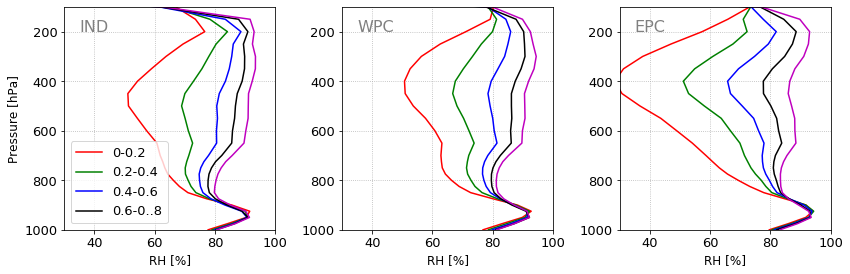

In [46]:
cover_cri = np.array([0,0.2,0.4,0.6,0.8,1])
rh_binIND = np.zeros((len(cover_cri)-1,len(lev)))
rh_binWPC = np.zeros((len(cover_cri)-1,len(lev)))
rh_binEPC = np.zeros((len(cover_cri)-1,len(lev)))

for i in range(len(cover_cri)-1):
    idx1 = np.where(np.logical_and(cldfrac_IND[:,24]>=cover_cri[i]
                                 ,cldfrac_IND[:,24]<cover_cri[i+1]))[0]
    idx2 = np.where(np.logical_and(cldfrac_WPC[:,24]>=cover_cri[i]
                                 ,cldfrac_WPC[:,24]<cover_cri[i+1]))[0]
    idx3 = np.where(np.logical_and(cldfrac_EPC[:,24]>=cover_cri[i]
                                 ,cldfrac_EPC[:,24]<cover_cri[i+1]))[0]
    rh_tmp1 = rh_IND[idx1,24,:] # to 1 hpa
    rh_tmp2 = rh_WPC[idx2,24,:]
    rh_tmp3 = rh_EPC[idx3,24,:]
    
    rh_binIND[i,:] = np.nanmean(rh_tmp1,axis=0)
    rh_binWPC[i,:] = np.nanmean(rh_tmp2,axis=0)
    rh_binEPC[i,:] = np.nanmean(rh_tmp3,axis=0)

fig,ax = plt.subplots(1,3,figsize=(12,4))
colors = ['r','g','b','k','m']
for n in range(5):
    ax[0].plot(rh_binIND[n,:]*100,lev,color=colors[n])
    ax[1].plot(rh_binWPC[n,:]*100,lev,color=colors[n])
    ax[2].plot(rh_binEPC[n,:]*100,lev,color=colors[n])
ax[0].set_ylim([1000,100]);ax[0].set_xlim([30,100])
ax[1].set_ylim([1000,100]);ax[1].set_xlim([30,100])
ax[2].set_ylim([1000,100]);ax[2].set_xlim([30,100])
ax[0].text(35,200,'IND',fontsize=16,color='grey')
ax[1].text(35,200,'WPC',fontsize=16,color='grey')
ax[2].text(35,200,'EPC',fontsize=16,color='grey')
ax[0].legend(['0-0.2','0.2-0.4','0.4-0.6','0.6-0..8'],loc=3)
ax[0].grid(linestyle=':');ax[1].grid(linestyle=':');ax[2].grid(linestyle=':')
ax[0].set_ylabel('Pressure [hPa]',fontsize=12)
ax[0].set_xlabel('RH [%]',fontsize=12)
ax[1].set_xlabel('RH [%]',fontsize=12)
ax[2].set_xlabel('RH [%]',fontsize=12)

plt.tight_layout()

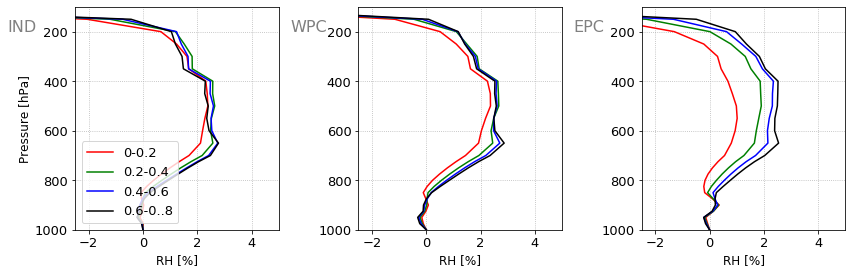

In [47]:
cover_cri = np.linspace(0,0.8,5)
buoy_binIND = np.zeros((len(cover_cri)-1,len(lev)))
buoy_binWPC = np.zeros((len(cover_cri)-1,len(lev)))
buoy_binEPC = np.zeros((len(cover_cri)-1,len(lev)))

for i in range(len(cover_cri)-1):
    idx1 = np.where(np.logical_and(cldfrac_IND[:,24]>=cover_cri[i]
                                 ,cldfrac_IND[:,24]<cover_cri[i+1]))[0]
    idx2 = np.where(np.logical_and(cldfrac_WPC[:,24]>=cover_cri[i]
                                 ,cldfrac_WPC[:,24]<cover_cri[i+1]))[0]
    idx3 = np.where(np.logical_and(cldfrac_EPC[:,24]>=cover_cri[i]
                                 ,cldfrac_EPC[:,24]<cover_cri[i+1]))[0]
    buoy_tmp1 = buoy_IND[idx1,26,:] # to 1 hpa
    buoy_tmp2 = buoy_WPC[idx2,26,:]
    buoy_tmp3 = buoy_EPC[idx3,26,:]
    
    buoy_binIND[i,:] = np.nanmean(buoy_tmp1,axis=0)
    buoy_binWPC[i,:] = np.nanmean(buoy_tmp2,axis=0)
    buoy_binEPC[i,:] = np.nanmean(buoy_tmp3,axis=0)
    
fig,ax = plt.subplots(1,3,figsize=(12,4))
colors = ['r','g','b','k']
for n in range(4):
    ax[0].plot(buoy_binIND[n,:],lev,color=colors[n])
    ax[1].plot(buoy_binWPC[n,:],lev,color=colors[n])
    ax[2].plot(buoy_binEPC[n,:],lev,color=colors[n])
ax[0].set_ylim([1000,100]);ax[0].set_xlim([-2.5,5])
ax[1].set_ylim([1000,100]);ax[1].set_xlim([-2.5,5])
ax[2].set_ylim([1000,100]);ax[2].set_xlim([-2.5,5])
ax[0].text(-5,200,'IND',fontsize=16,color='grey')
ax[1].text(-5,200,'WPC',fontsize=16,color='grey')
ax[2].text(-5,200,'EPC',fontsize=16,color='grey')
ax[0].legend(['0-0.2','0.2-0.4','0.4-0.6','0.6-0..8'],loc=3)
ax[0].grid(linestyle=':');ax[1].grid(linestyle=':');ax[2].grid(linestyle=':')
ax[0].set_ylabel('Pressure [hPa]',fontsize=12)
ax[0].set_xlabel('RH [%]',fontsize=12)
ax[1].set_xlabel('RH [%]',fontsize=12)
ax[2].set_xlabel('RH [%]',fontsize=12)

plt.tight_layout()

In [48]:
# CRH vs cloud cover 
crh_cri = np.array([0,0.5,0.65,0.8,1])
cover_cri = np.array([0,0.2,0.4,0.6,0.8,1])
cover_bin = np.zeros((len(crh_cri)-1,len(cover_cri)-1))
precm_bin = np.copy(cover_bin)
precste_bin = np.copy(cover_bin)
SCAIbt_bin = np.copy(cover_bin)
SCAIbtste_bin = np.copy(cover_bin)

for n in range(len(crh_cri)-1):
    idx = np.where(np.logical_and(crh_EPC[:,24]>=crh_cri[n],crh_EPC[:,24]<crh_cri[n+1]))[0]
    
    cover_tmp = cldfrac_EPC[idx,:]
    prec_tmp = prec_EPC[idx,:]
    SCAIbt_tmp = SCAIbt_EPC[idx,:]
    
    for i in range(len(cover_cri)-1):
        idx2 = np.where(np.logical_and(cover_tmp[:,24]>=cover_cri[i]
                                      ,cover_tmp[:,24]<cover_cri[i+1]))[0]
        cover_bin[n,i] = len(idx2)
        precm_bin[n,i] = np.nanmean(prec_tmp[idx2,24])
        precste_bin[n,i] = np.nanstd(prec_tmp[idx2,24])/len(idx2)**0.5
        SCAIbt_bin[n,i] = np.nanmean(SCAIbt_tmp[idx2,24])
        SCAIbtste_bin[n,i] = np.nanstd(SCAIbt_tmp[idx2,24])/len(idx2)**0.5

In [49]:
# joint histogram CRH, cloud fraction for all 
crh_bin = np.linspace(0,1,21)
cldfrac_bin = np.linspace(0,1,21)
hist_bin_cf = np.zeros((len(crh_bin)-1,len(cldfrac_bin)-1))
hist_bin_cfp = np.zeros((len(crh_bin)-1,len(cldfrac_bin)-1))

for i in range(len(cldfrac_bin)-1):
    for j in range(len(crh_bin)-1):
        
        idx = np.where(np.logical_and(crh_all[:,24]>=crh_bin[i],crh_all[:,24]<crh_bin[i+1]))[0]
        idx2 = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[j]
                                       ,cldfrac_all[:,24]<cldfrac_bin[j+1]))[0]
        idx = np.intersect1d(idx,idx2)
        hist_bin_cf[i,j] = len(idx)
        hist_bin_cfp[i,j] = np.nanmean(prec_all[idx,24])

In [50]:
# joint histogram CRH, Abar for all 
Abar_bin = np.linspace(0,400,21)
crh_bin = np.linspace(0,1,21)
hist_bin_A = np.zeros((len(Abar_bin)-1,len(cldfrac_bin)-1))
hist_bin_Ap = np.zeros((len(Abar_bin)-1,len(cldfrac_bin)-1))

for i in range(len(Abar_bin)-1):
    for j in range(len(crh_bin)-1):
        
        idx = np.where(np.logical_and(crh_all[:,24]>=crh_bin[i],crh_all[:,24]<crh_bin[i+1]))[0]
        idx2 = np.where(np.logical_and(Abar_all[:,24]>=Abar_bin[j]
                                       ,Abar_all[:,24]<Abar_bin[j+1]))[0]
        idx = np.intersect1d(idx,idx2)
        hist_bin_A[i,j] = len(idx)
        hist_bin_Ap[i,j] = np.nanmean(prec_all[idx,24])

In [51]:
# add row and column for pcolor
hist_bin_cf = np.vstack([np.zeros((hist_bin_cf.shape[1])),hist_bin_cf])
hist_bin_cf = np.vstack([hist_bin_cf.T,np.zeros((hist_bin_cf.shape[0])).T]).T

hist_bin_cfp = np.vstack([np.zeros((hist_bin_cfp.shape[1])),hist_bin_cfp])
hist_bin_cfp = np.vstack([hist_bin_cfp.T,np.zeros((hist_bin_cfp.shape[0])).T]).T

hist_bin_A = np.vstack([np.zeros((hist_bin_A.shape[1])),hist_bin_A])
hist_bin_A = np.vstack([hist_bin_A.T,np.zeros((hist_bin_A.shape[0])).T]).T

hist_bin_Ap = np.vstack([np.zeros((hist_bin_Ap.shape[1])),hist_bin_Ap])
hist_bin_Ap = np.vstack([hist_bin_Ap.T,np.zeros((hist_bin_Ap.shape[0])).T]).T

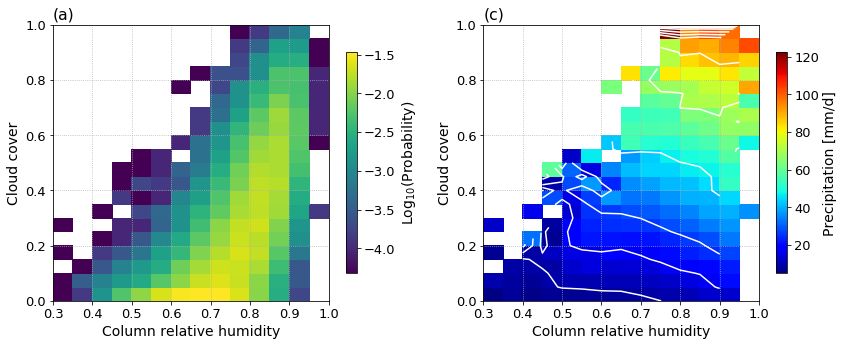

In [52]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ps1 = ax[0].pcolormesh(crh_bin,cldfrac_bin,np.log10(hist_bin_cf.T/np.sum(hist_bin_cf))[:-1,:-1])
cbar = plt.colorbar(ps1,ax=ax[0],shrink=0.8)
cbar.set_label('Log$_{10}$(Probability)',fontsize=14)
ax[0].set_xlabel('Column relative humidity',fontsize=14);ax[0].set_ylabel('Cloud cover',fontsize=14)
ax[0].set_xlim([0.3,1]);ax[0].set_ylim([0,1])
ax[0].set_title('(a)',loc='left');ax[0].grid(linestyle=':')
plt.rcParams.update({'font.size': 13})

ps2 = ax[1].pcolormesh(crh_bin,cldfrac_bin,hist_bin_cfp.T[:-1,:-1]*24,cmap='jet',vmin=5)
cbar = plt.colorbar(ps2,ax=ax[1],shrink=0.8)
cbar.set_label('Precipitation [mm/d]',fontsize=14)
ax[1].contour(crh_bin,cldfrac_bin,hist_bin_cfp.T*24,levels=[10,20,30,50,70,90],colors=['w'],linewidths=1.5)
ax[1].set_xlabel('Column relative humidity',fontsize=14);ax[1].set_ylabel('Cloud cover',fontsize=14)
ax[1].set_xlim([0.3,1]);ax[1].set_ylim([0,1]);ax[1].grid(linestyle=':')
ax[1].set_title('(c)',loc='left')

plt.tight_layout()
fig.savefig(fig_dir+'CFAD_cloudcover_CRH.pdf',bbox_inches='tight')

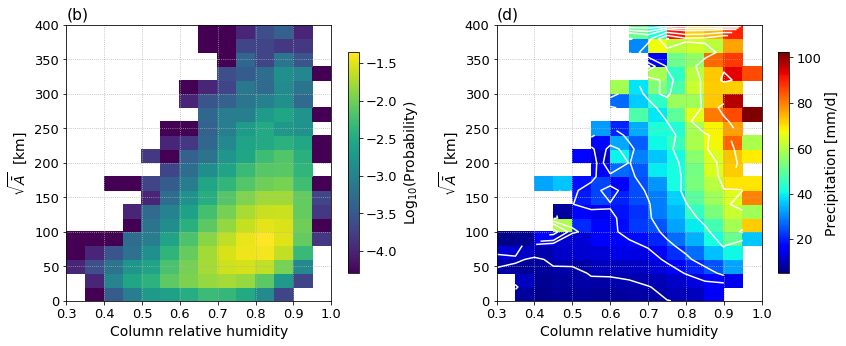

In [53]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ps1 = ax[0].pcolormesh(crh_bin,Abar_bin,np.log10(hist_bin_A.T/np.sum(hist_bin_A))[:-1,:-1])
cbar = plt.colorbar(ps1,ax=ax[0],shrink=0.8)
cbar.set_label('Log$_{10}$(Probability)',fontsize=14)
ax[0].set_xlabel('Column relative humidity',fontsize=14);ax[0].set_ylabel(r'$\sqrt{\bar{A}}$  [km]',fontsize=14)
ax[0].set_xlim([0.3,1]);ax[0].set_ylim([0,400]);ax[0].grid(linestyle=':')
plt.rcParams.update({'font.size': 13})
ax[0].set_title('(b)',loc='left');ax[0].grid(linestyle=':')
ax[0].set_xticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

ps2 = ax[1].pcolormesh(crh_bin,Abar_bin,hist_bin_Ap.T[:-1,:-1]*24,cmap='jet',vmin=5)
cbar = plt.colorbar(ps2,ax=ax[1],shrink=0.8)
cbar.set_label('Precipitation [mm/d]',fontsize=14)
ax[1].contour(crh_bin,Abar_bin,hist_bin_Ap.T*24,levels=[10,20,30,50,70,90],colors=['w'])
ax[1].set_xlabel('Column relative humidity',fontsize=14);ax[1].set_ylabel(r'$\sqrt{\bar{A}}$  [km]',fontsize=14)
ax[1].set_xlim([0.3,1]);ax[1].set_ylim([0,400]);ax[1].grid(linestyle=':')
ax[1].set_title('(d)',loc='left');ax[0].grid(linestyle=':')
ax[1].set_xticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

plt.tight_layout()
fig.savefig(fig_dir+'CFAD_Abar_CRH.pdf',bbox_inches='tight')

### Grouping by cldfrac and Abar

In [54]:
def idx_group(var1_all,v1_lbound,v1_ubound,var2_all,v2_lbound,v2_ubound):
    
    idx1 = np.where(np.logical_and(var1_all[:,24]>=v1_lbound,var1_all[:,24]<v1_ubound))[0]
    idx2 = np.where(np.logical_and(var2_all[:,24]>=v2_lbound,var2_all[:,24]<v2_ubound))[0]
    idx = np.intersect1d(idx1,idx2)
    
    return idx

In [55]:
def qvint_layer(q_all,T_all,lev,lp,up):
    
    # partial cwv
    idx = np.where(np.logical_and(lev<=lp,lev>up))[0]
    q_layer = q_all[:,:,idx]
    T_layer = T_all[:,:,idx]
    
    lev_layer = np.tile(lev[idx],(T_layer.shape[0],T_layer.shape[1]))
    lev_layer = (lev_layer.reshape(T_layer.shape[0],T_layer.shape[1],len(lev[idx])))
        
    ro_layer = lev_layer*100/(287.15*T_layer)
    vint_layer = -np.trapz(q_layer/ro_layer,lev_layer*100,axis=2)/9.8 # vertical integral of q    
    
    return vint_layer

In [56]:
# event separation by cloud cover (convective scale) and CRH 
idx_G1 = idx_group(cldfrac_all,0,0.1,crh_all,0,1)
idx_G2 = idx_group(cldfrac_all,0.1,0.2,crh_all,0,1)
idx_G3 = idx_group(cldfrac_all,0.2,0.4,crh_all,0,1)
idx_G4 = idx_group(cldfrac_all,0.4,0.6,crh_all,0,1)
idx_G5 = idx_group(cldfrac_all,0.6,1,crh_all,0,1)

In [ ]:
qvint_G1_BL,qvint_G1_LF,qvint_G1_MF = (qvint_layer(q_all[idx_G1,:,:],T_all[idx_G1,:,:],lev,1000,900),
                                       qvint_layer(q_all[idx_G1,:,:],T_all[idx_G1,:,:],lev,900,700),
                                       qvint_layer(q_all[idx_G1,:,:],T_all[idx_G1,:,:],lev,700,500))

qvint_G2_BL,qvint_G2_LF,qvint_G2_MF = (qvint_layer(q_all[idx_G2,:,:],T_all[idx_G2,:,:],lev,1000,900),
                                       qvint_layer(q_all[idx_G2,:,:],T_all[idx_G2,:,:],lev,900,700),
                                       qvint_layer(q_all[idx_G2,:,:],T_all[idx_G2,:,:],lev,700,500))

qvint_G3_BL,qvint_G3_LF,qvint_G3_MF = (qvint_layer(q_all[idx_G3,:,:],T_all[idx_G3,:,:],lev,1000,900),
                                       qvint_layer(q_all[idx_G3,:,:],T_all[idx_G3,:,:],lev,900,700),
                                       qvint_layer(q_all[idx_G3,:,:],T_all[idx_G3,:,:],lev,700,500))

qvint_G4_BL,qvint_G4_LF,qvint_G4_MF = (qvint_layer(q_all[idx_G4,:,:],T_all[idx_G4,:,:],lev,1000,900),
                                       qvint_layer(q_all[idx_G4,:,:],T_all[idx_G4,:,:],lev,900,700),
                                       qvint_layer(q_all[idx_G4,:,:],T_all[idx_G4,:,:],lev,700,500))

qvint_G5_BL,qvint_G5_LF,qvint_G5_MF = (qvint_layer(q_all[idx_G5,:,:],T_all[idx_G5,:,:],lev,1000,900),
                                       qvint_layer(q_all[idx_G5,:,:],T_all[idx_G5,:,:],lev,900,700),
                                       qvint_layer(q_all[idx_G5,:,:],T_all[idx_G5,:,:],lev,700,500))

In [ ]:
fig = plt.figure(figsize=(6,5))
plt.plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G1,:],axis=0),'xk',markersize=8,
        markerfacecolor='None')
plt.plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G2,:],axis=0),'or',markersize=8,
        markerfacecolor='None')
plt.plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G3,:],axis=0),'^g',markersize=8,
        markerfacecolor='None')
plt.plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G4,:],axis=0),'db',markersize=8,
        markerfacecolor='None')
plt.plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G5,:],axis=0),'sm',markersize=8,
        markerfacecolor='None')

plt.vlines(x=0,ymin=40,ymax=65,linestyle='-',linewidth=0.5);plt.ylim([40,65])
plt.legend(['0-0.1','0.1-0.2','0.2-0.4','0.4-0.6','0.6-0.8'])
plt.xlabel('hour',fontsize=14);plt.ylabel('CWV [mm]',fontsize=14)

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,8))

ax[0,0].plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G1,:],axis=0),'xk',markersize=6,
        markerfacecolor='None')
ax[0,0].plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G2,:],axis=0),'or',markersize=6,
        markerfacecolor='None')
ax[0,0].plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G3,:],axis=0),'^g',markersize=6,
        markerfacecolor='None')
ax[0,0].plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G4,:],axis=0),'db',markersize=6,
        markerfacecolor='None')
ax[0,0].plot(np.arange(-72,75,3),np.nanmean(cwv_all[idx_G5,:],axis=0),'sm',markersize=6,
        markerfacecolor='None')
ax[0,0].vlines(x=0,ymin=0,ymax=70,linestyles='-',linewidth=0.5);ax[0,0].set_ylim([39,62])
ax[0,0].legend(['0-0.1','0.1-0.2','0.2-0.4','0.4-0.6','0.6-1'],fontsize=8,loc=2)

ax[0,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G1_BL,axis=0),'xk',markersize=6,
        markerfacecolor='None')
ax[0,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G2_BL,axis=0),'or',markersize=6,
        markerfacecolor='None')
ax[0,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G3_BL,axis=0),'^g',markersize=6,
        markerfacecolor='None')
ax[0,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G4_BL,axis=0),'db',markersize=6,
        markerfacecolor='None')
ax[0,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G5_BL,axis=0),'sm',markersize=6,
        markerfacecolor='None')
ax[0,1].vlines(x=0,ymin=0,ymax=50,linestyles='-',linewidth=0.5);ax[0,1].set_ylim([10,11.6])

ax[1,0].plot(np.arange(-72,75,3),np.nanmean(qvint_G1_LF,axis=0),'xk',markersize=6,
        markerfacecolor='None')
ax[1,0].plot(np.arange(-72,75,3),np.nanmean(qvint_G2_LF,axis=0),'or',markersize=6,
        markerfacecolor='None')
ax[1,0].plot(np.arange(-72,75,3),np.nanmean(qvint_G3_LF,axis=0),'^g',markersize=6,
        markerfacecolor='None')
ax[1,0].plot(np.arange(-72,75,3),np.nanmean(qvint_G4_LF,axis=0),'db',markersize=6,
        markerfacecolor='None')
ax[1,0].plot(np.arange(-72,75,3),np.nanmean(qvint_G5_LF,axis=0),'sm',markersize=6,
        markerfacecolor='None')
ax[1,0].vlines(x=0,ymin=0,ymax=50,linestyles='-',linewidth=0.5);ax[1,0].set_ylim([14.5,20.5])

ax[1,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G1_MF,axis=0),'xk',markersize=6,
        markerfacecolor='None')
ax[1,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G2_MF,axis=0),'or',markersize=6,
        markerfacecolor='None')
ax[1,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G3_MF,axis=0),'^g',markersize=6,
        markerfacecolor='None')
ax[1,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G4_MF,axis=0),'db',markersize=6,
        markerfacecolor='None')
ax[1,1].plot(np.arange(-72,75,3),np.nanmean(qvint_G5_MF,axis=0),'sm',markersize=6,
        markerfacecolor='None')
ax[1,1].vlines(x=0,ymin=0,ymax=50,linestyles='-',linewidth=0.5);ax[1,1].set_ylim([5,15])

ax[0,0].set_title('<Q$_v$>, all');ax[0,0].set_ylabel('[g/kg]',fontsize=14)
ax[0,0].set_xlabel('hour',fontsize=13);ax[0,0].grid(linestyle=':');ax[0,0].set_xlim([-73,73])
ax[0,1].set_title('<Q$_v$>$_{BL}$, 1000-900 hPa');ax[0,1].set_ylabel('[g/kg]',fontsize=13)
ax[0,1].set_xlabel('hour',fontsize=13);ax[0,1].grid(linestyle=':');ax[0,1].set_xlim([-73,73])
ax[1,0].set_title('<Q$_v$>$_{LF}$, 900-700 hPa');ax[1,0].set_ylabel('[g/kg]',fontsize=13)
ax[1,0].set_xlabel('hour',fontsize=13);ax[1,0].grid(linestyle=':');ax[1,0].set_xlim([-73,73])
ax[1,1].set_title('<Q$_v$>$_{MF}$, 700-500 hPa');ax[1,1].set_ylabel('[g/kg]',fontsize=13)
ax[1,1].set_xlabel('hour',fontsize=13);ax[1,1].grid(linestyle=':');ax[1,1].set_xlim([-73,73])

ax[0,0].set_xticks([-72,-60,-48,-36,-24,-12,0,12,24,36,48,60,72])
ax[0,1].set_xticks([-72,-60,-48,-36,-24,-12,0,12,24,36,48,60,72])
ax[1,0].set_xticks([-72,-60,-48,-36,-24,-12,0,12,24,36,48,60,72])
ax[1,1].set_xticks([-72,-60,-48,-36,-24,-12,0,12,24,36,48,60,72])

plt.rcParams.update({'font.size':11})
plt.tight_layout()
fig.savefig(fig_dir+'qvint_evolution_multilayers.pdf',bbox_inches='tight')

In [ ]:
# mean cloud top pressure
fig = plt.figure(figsize=(6,4))

plt.plot(np.arange(-72,75,3),np.nanmean(ctp_all[idx_G1,:],axis=0),'-xk',
        markersize=8,markerfacecolor='None',linewidth=0.5)
plt.plot(np.arange(-72,75,3),np.nanmean(ctp_all[idx_G2,:],axis=0),'-or',
        markersize=8,markerfacecolor='None',linewidth=0.5)
plt.plot(np.arange(-72,75,3),np.nanmean(ctp_all[idx_G3,:],axis=0),'-^g',
        markersize=8,markerfacecolor='None',linewidth=0.5)
plt.plot(np.arange(-72,75,3),np.nanmean(ctp_all[idx_G4,:],axis=0),'-db',
        markersize=8,markerfacecolor='None',linewidth=0.5)
plt.plot(np.arange(-72,75,3),np.nanmean(ctp_all[idx_G5,:],axis=0),'-sm',        
        markersize=8,markerfacecolor='None',linewidth=0.5)
plt.legend(['0-0.1','0.1-0.2','0.2-0.4','0.4-0.6','0.6-1'],fontsize=8,loc=1)


plt.hlines(y=500,xmin=-72,xmax=72,linestyles='-',linewidth=0.5)
plt.hlines(y=700,xmin=-72,xmax=72,linestyles='-',linewidth=0.5)
plt.vlines(x=0,ymin=200,ymax=1000,linestyles='-',linewidth=0.5)
plt.ylim([900,200])
plt.xticks([-72,-60,-48,-36,-24,-12,0,12,24,36,48,60,72])
plt.xlabel('hour',fontsize=12)


plt.ylabel('Cloud top pressure [hPa]',fontsize=12)
plt.grid(linestyle=':');plt.xlim([-73,73])
fig.savefig(fig_dir+'CTP_evoluion.pdf',bbox_inches='tight')

In [ ]:
# cldscale dist

#### Moisture budget analysis based on cloud scale

In [ ]:
# column-integrated moisture flux 
qvflux_vint_all = np.trapz(qvflux_all,lev*100,axis=2)/9.8

In [ ]:
# extend SFX array
LHF_allre = np.zeros((len(time_event),49))
for n in range(len(time_event)):
    LHF_allre[n,:48] = LHF_all[n,:]
    LHF_allre[n,48] = LHF_all[n,-1]

In [ ]:
# TQLI local tendency
#TQLI_tend = np.gradient(TQLI_all,3,axis=1)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G1,:],axis=0),'-xk'
        ,markersize=6,markerfacecolor='None')
ax.plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G2,:],axis=0),'-or'
        ,markersize=6,markerfacecolor='None')
ax.plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G3,:],axis=0),'-^g'
        ,markersize=6,markerfacecolor='None')
ax.plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G4,:],axis=0),'-db'
        ,markersize=6,markerfacecolor='None')
ax.plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G5,:],axis=0),'-sm'
        ,markersize=6,markerfacecolor='None')
ax.plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[:,:],axis=0),'-'
        ,color='grey',linewidth=4)


In [ ]:
# SFX grouped by idx_AM, area-binned, moist 
fig,ax = plt.subplots(5,1,figsize=(10,10))
ax[0].plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G1,:]/2.5e6*86400,axis=0),'-g',linewidth=1.5)
ax[1].plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G2,:]/2.5e6*86400,axis=0),'-g',linewidth=1.5)
ax[2].plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G3,:]/2.5e6*86400,axis=0),'-g',linewidth=1.5)
ax[3].plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G4,:]/2.5e6*86400,axis=0),'-g',linewidth=1.5)
ax[4].plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[idx_G5,:]/2.5e6*86400,axis=0),'-g',linewidth=1.5)

ax[0].plot(np.linspace(-72,72,49),np.nanmean(qvflux_vint_all[idx_G1,:]*86400,axis=0),color='navy',linewidth=1.5)
ax[1].plot(np.linspace(-72,72,49),np.nanmean(qvflux_vint_all[idx_G2,:]*86400,axis=0),color='navy',linewidth=1.5)
ax[2].plot(np.linspace(-72,72,49),np.nanmean(qvflux_vint_all[idx_G3,:]*86400,axis=0),color='navy',linewidth=1.5)
ax[3].plot(np.linspace(-72,72,49),np.nanmean(qvflux_vint_all[idx_G4,:]*86400,axis=0),color='navy',linewidth=1.5)
ax[4].plot(np.linspace(-72,72,49),np.nanmean(qvflux_vint_all[idx_G5,:]*86400,axis=0),color='navy',linewidth=1.5)

ax[0].plot(np.linspace(-72,72,49),np.nanmean(-prec_all[idx_G1,:]*24,axis=0),color='darkorange',linewidth=1.5)
ax[1].plot(np.linspace(-72,72,49),np.nanmean(-prec_all[idx_G2,:]*24,axis=0),color='darkorange',linewidth=1.5)
ax[2].plot(np.linspace(-72,72,49),np.nanmean(-prec_all[idx_G3,:]*24,axis=0),color='darkorange',linewidth=1.5)
ax[3].plot(np.linspace(-72,72,49),np.nanmean(-prec_all[idx_G4,:]*24,axis=0),color='darkorange',linewidth=1.5)
ax[4].plot(np.linspace(-72,72,49),np.nanmean(-prec_all[idx_G5,:]*24,axis=0),color='darkorange',linewidth=1.5)

# net mositure storage based on the budget equation
net1 = np.nanmean(LHF_allre[idx_G1,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G1,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G1,:]*24,axis=0)
net1_p = np.copy(net1); net1_p[net1_p<0] = np.nan
net1_n = np.copy(net1); net1_n[net1_n>0] = np.nan
net2 = np.nanmean(LHF_allre[idx_G2,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G2,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G2,:]*24,axis=0)
net2_p = np.copy(net2); net2_p[net2_p<0] = np.nan
net2_n = np.copy(net2); net2_n[net2_n>0] = np.nan
net3 = np.nanmean(LHF_allre[idx_G3,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G3,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G3,:]*24,axis=0)
net3_p = np.copy(net3); net3_p[net3_p<0] = np.nan
net3_n = np.copy(net3); net3_n[net3_n>0] = np.nan
net4 = np.nanmean(LHF_allre[idx_G4,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G4,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G4,:]*24,axis=0)
net4_p = np.copy(net4); net4_p[net4_p<0] = np.nan
net4_n = np.copy(net4); net4_n[net4_n>0] = np.nan
net5 = np.nanmean(LHF_allre[idx_G5,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G5,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G5,:]*24,axis=0)
net5_p = np.copy(net5); net5_p[net5_p<0] = np.nan
net5_n = np.copy(net5); net5_n[net5_n>0] = np.nan

ax[0].bar(np.linspace(-72,72,49),net1_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[0].bar(np.linspace(-72,72,49),net1_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')
ax[1].bar(np.linspace(-72,72,49),net2_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[1].bar(np.linspace(-72,72,49),net2_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')
ax[2].bar(np.linspace(-72,72,49),net3_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[2].bar(np.linspace(-72,72,49),net3_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')
ax[3].bar(np.linspace(-72,72,49),net4_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[3].bar(np.linspace(-72,72,49),net4_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')
ax[4].bar(np.linspace(-72,72,49),net5_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[4].bar(np.linspace(-72,72,49),net5_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')

ax[0].set_xlim([-72,72]);ax[0].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax[1].set_xlim([-72,72]);ax[1].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax[2].set_xlim([-72,72]);ax[2].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax[3].set_xlim([-72,72]);ax[3].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax[4].set_xlim([-72,72]);ax[4].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)

ax[0].set_ylim([-10,10]);ax[1].set_ylim([-15,10]);ax[2].set_ylim([-25,10])
ax[3].set_ylim([-40,20]);ax[4].set_ylim([-50,20])

ax[0].set_ylabel('[mm/day]',fontsize=12)
ax[1].set_ylabel('[mm/day]',fontsize=12)
ax[2].set_ylabel('[mm/day]',fontsize=12)
ax[3].set_ylabel('[mm/day]',fontsize=12)
ax[4].set_ylabel('[mm/day]',fontsize=12)
ax[4].set_xlabel('hour',fontsize=12)

ax[0].grid(linestyle=':',color='grey',linewidth=0.05);ax[0].set_xticks(np.arange(-72,84,12))
ax[1].grid(linestyle=':',color='grey',linewidth=0.05);ax[1].set_xticks(np.arange(-72,84,12))
ax[2].grid(linestyle=':',color='grey',linewidth=0.05);ax[2].set_xticks(np.arange(-72,84,12))
ax[3].grid(linestyle=':',color='grey',linewidth=0.05);ax[3].set_xticks(np.arange(-72,84,12))
ax[4].grid(linestyle=':',color='grey',linewidth=0.05);ax[4].set_xticks(np.arange(-72,84,12))

ax[0].set_xticklabels(labels=[])
ax[1].set_xticklabels(labels=[])
ax[2].set_xticklabels(labels=[])
ax[3].set_xticklabels(labels=[])

#ax[0].set_title('Column-integrated moisture budget analysis, Qv_ten = QF + LHF - P',fontsize=13)
ax[0].legend(['LHF','MFlux','Prec','<Q$_v$>$_{ten}$'], loc=1,
       ncol=4, borderaxespad=0.2, frameon=False, fontsize=9)
plt.rcParams.update({'font.size':10})

ax[0].text(66,-9.5,'(a)',fontsize=13)
ax[1].text(66,-14.5,'(b)',fontsize=13)
ax[2].text(66,-24.5,'(c)',fontsize=13)
ax[3].text(66,-39.5,'(d)',fontsize=13)
ax[4].text(66,-49.5,'(e)',fontsize=13)

plt.show()

fig.savefig(fig_dir+'MoistBA_scales.pdf',bbox_inches='tight')

In [ ]:
# SFX grouped by idx_AM, area-binned, moist 
fig,ax = plt.subplots(1,1,figsize=(10,2))
ax.plot(np.linspace(-72,72,49),np.nanmean(LHF_allre[:,:]/2.5e6*86400,axis=0),'-g',linewidth=1.5)
ax.plot(np.linspace(-72,72,49),np.nanmean(qvflux_vint_all[:,:]*86400,axis=0),color='navy',linewidth=1.5)
ax.plot(np.linspace(-72,72,49),np.nanmean(-prec_all[:,:]*24,axis=0),color='darkorange',linewidth=1.5)

# net mositure storage based on the budget equation
net1 = np.nanmean(LHF_allre[:,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[:,:]*86400,axis=0)- \
             np.nanmean(prec_all[:,:]*24,axis=0)

#ax.fill_between(np.linspace(-72,72,49),net1, 0, where=net1>0, facecolor='b',interpolate=True,alpha=0.4)
#ax.fill_between(np.linspace(-72,72,49),net1, 0, where=net1<0, facecolor='r',interpolate=True,alpha=0.4)
net1_p = np.copy(net1); net1_p[net1_p<0] = np.nan
net1_n = np.copy(net1); net1_n[net1_n>0] = np.nan

ax.bar(np.linspace(-72,72,49),net1_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax.bar(np.linspace(-72,72,49),net1_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')

ax.set_xlim([-72,72]);ax.hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax.set_ylim([-10,10])
ax.set_ylabel('[mm/day]',fontsize=13)

ax.grid(linestyle=':',color='grey',linewidth=0.05);ax.set_xticks(np.arange(-72,84,12))
ax.set_xlabel('hour',fontsize=13)
#ax.set_title('Column-integrated moisture budget analysis, Qv_ten = QF + LHF - P',fontsize=13)
ax.legend(['Evap','MFlux','Prec',r'$\langle Q_v \rangle_t$'], loc=1,
       ncol=4, borderaxespad=0.2, frameon=False, fontsize=9)
plt.rcParams.update({'font.size':10})
plt.show()
fig.savefig(fig_dir+'MoistBA_allevents.pdf',bbox_inches='tight')

In [ ]:
# SFX grouped by idx_AM, area-binned, moist 
fig,ax = plt.subplots(5,1,figsize=(10,10))

# net mositure storage based on the budget equation
net1 = np.nanmean(LHF_allre[idx_G1,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G1,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G1,:]*24,axis=0)
net1_p = np.copy(net1); net1_p[net1_p<0] = np.nan
net1_n = np.copy(net1); net1_n[net1_n>0] = np.nan
net2 = np.nanmean(LHF_allre[idx_G2,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G2,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G2,:]*24,axis=0)
net2_p = np.copy(net2); net2_p[net2_p<0] = np.nan
net2_n = np.copy(net2); net2_n[net2_n>0] = np.nan
net3 = np.nanmean(LHF_allre[idx_G3,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G3,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G3,:]*24,axis=0)
net3_p = np.copy(net3); net3_p[net3_p<0] = np.nan
net3_n = np.copy(net3); net3_n[net3_n>0] = np.nan
net4 = np.nanmean(LHF_allre[idx_G4,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G4,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G4,:]*24,axis=0)
net4_p = np.copy(net4); net4_p[net4_p<0] = np.nan
net4_n = np.copy(net4); net4_n[net4_n>0] = np.nan
net5 = np.nanmean(LHF_allre[idx_G5,:]/2.5e6*86400,axis=0)+ \
             np.nanmean(qvflux_vint_all[idx_G5,:]*86400,axis=0)- \
             np.nanmean(prec_all[idx_G5,:]*24,axis=0)
net5_p = np.copy(net5); net5_p[net5_p<0] = np.nan
net5_n = np.copy(net5); net5_n[net5_n>0] = np.nan

ax[0].bar(np.linspace(-72,72,49),net1_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[0].bar(np.linspace(-72,72,49),net1_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')
ax[1].bar(np.linspace(-72,72,49),net2_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[1].bar(np.linspace(-72,72,49),net2_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')
ax[2].bar(np.linspace(-72,72,49),net3_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[2].bar(np.linspace(-72,72,49),net3_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')
ax[3].bar(np.linspace(-72,72,49),net4_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[3].bar(np.linspace(-72,72,49),net4_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')
ax[4].bar(np.linspace(-72,72,49),net5_p,align='center',width=3,alpha=0.4,edgecolor='grey')
ax[4].bar(np.linspace(-72,72,49),net5_n,align='center',width=3,color='r',alpha=0.4,edgecolor='grey')

ax[0].set_xlim([-72,72]);ax[0].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax[1].set_xlim([-72,72]);ax[1].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax[2].set_xlim([-72,72]);ax[2].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax[3].set_xlim([-72,72]);ax[3].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)
ax[4].set_xlim([-72,72]);ax[4].hlines(y=0,xmin=-72,xmax=600,linewidth=0.5,zorder=3)

ax[0].set_ylim([-10,10]);ax[1].set_ylim([-10,10]);ax[2].set_ylim([-10,10])
ax[3].set_ylim([-10,10]);ax[4].set_ylim([-10,10])

ax[0].set_ylabel('[mm/day]',fontsize=12)
ax[1].set_ylabel('[mm/day]',fontsize=12)
ax[2].set_ylabel('[mm/day]',fontsize=12)
ax[3].set_ylabel('[mm/day]',fontsize=12)
ax[4].set_ylabel('[mm/day]',fontsize=12)
ax[4].set_xlabel('hour',fontsize=12)

ax[0].grid(linestyle='--',color='grey',linewidth=0.2);ax[0].set_xticks(np.arange(-72,84,12))
ax[1].grid(linestyle='--',color='grey',linewidth=0.2);ax[1].set_xticks(np.arange(-72,84,12))
ax[2].grid(linestyle='--',color='grey',linewidth=0.2);ax[2].set_xticks(np.arange(-72,84,12))
ax[3].grid(linestyle='--',color='grey',linewidth=0.2);ax[3].set_xticks(np.arange(-72,84,12))
ax[4].grid(linestyle='--',color='grey',linewidth=0.2);ax[4].set_xticks(np.arange(-72,84,12))

ax[0].set_xticklabels(labels=[])
ax[1].set_xticklabels(labels=[])
ax[2].set_xticklabels(labels=[])
ax[3].set_xticklabels(labels=[])

ax[0].set_title('Column-integrated moisture budget analysis, Qv_ten = QF + LHF - P',fontsize=13)
ax[0].legend(['LHF','MFlux','Prec'], loc=1,
       ncol=3, borderaxespad=0.2, frameon=False)
plt.show()

In [ ]:
plt.plot(np.nanmean(rh_q1_all[idx_G4,24,:],axis=0)*100,lev,'sr')
plt.plot(np.nanmean(rh_q1_all[idx_G4,28,:],axis=0)*100,lev,'sg')
plt.plot(np.nanmean(rh_q1_all[idx_G4,32,:],axis=0)*100,lev,'sb')
plt.plot(np.nanmean(rh_q1_all[idx_G4,36,:],axis=0)*100,lev,'sm')

plt.plot(np.nanmean(rh_q1_all[idx_G1,24,:],axis=0)*100,lev,'r')
plt.plot(np.nanmean(rh_q1_all[idx_G1,28,:],axis=0)*100,lev,'g')
plt.plot(np.nanmean(rh_q1_all[idx_G1,32,:],axis=0)*100,lev,'b')
plt.plot(np.nanmean(rh_q1_all[idx_G1,36,:],axis=0)*100,lev,'m')

#plt.plot(np.nanmean(rh_q4_all[idx_G3,26,:],axis=0),lev,'g')
#plt.plot(np.nanmean(rh_q1_all[idx_G3,26,:],axis=0),lev,'--g')
#plt.plot(np.nanmean(rh_all[idx_G3,26,:],axis=0),lev,'-',color='grey',linewidth=1.5)
plt.ylim([1000,100])
# plt.plot(np.arange(-72,75,3),np.nanmean(crh_q4_all[idx_G3,:]-crh_q1_all[idx_G3,:],axis=0),'b')
# plt.plot(np.arange(-72,75,3),np.nanmean(crh_q4_all[idx_G4,:]-crh_q1_all[idx_G4,:],axis=0),'k')
# plt.plot(np.arange(-72,75,3),np.nanmean(crh_q4_all[idx_G5,:]-crh_q1_all[idx_G5,:],axis=0),'m')

#### occurrence map 

In [ ]:
# different catagory 
def freq_map_cat(lon_event,lat_event):
   
    lat_bin = np.linspace(-7.5,7.5,7)
    lon_bin = np.linspace(-177.5,177.5,143)

    freq_map = np.zeros((len(lon_bin),len(lat_bin)))

    for i in range(len(lon_bin)):
        for j in range(len(lat_bin)):
            idx = np.where(lon_event == lon_bin[i])[0]
            idy = np.where(lat_event == lat_bin[j])[0]
            
            if (lon_bin[i] >= 90) & (lon_bin[i]<=150):
                freq_map[i,j] = np.nan

            if len(np.intersect1d(idx,idy)) > 0:
                freq_map[i,j] += len(np.intersect1d(idx,idy))
    
    freq_map_re = np.zeros((145,7))
    freq_map_re[:143,:] = freq_map
    freq_map_re[143,:] = (freq_map[0,:]+freq_map[-1,:])/2
    freq_map_re[144,:] = (freq_map[0,:]+freq_map[-1,:])/2    
    freq_map_re = np.vstack([freq_map_re.T,np.zeros((freq_map_re.shape[0])).T]).T
    
    return freq_map_re

In [ ]:
lat_bin = np.linspace(-8.75,8.75,8)
lon_bin = np.linspace(-178.75,181.25,145)

freq_map_tot =  freq_map_cat(lon_event,lat_event)
freq_map_G1 = freq_map_cat(lon_event[idx_G1],lat_event[idx_G1])
freq_map_G2 = freq_map_cat(lon_event[idx_G2],lat_event[idx_G2])
freq_map_G3 = freq_map_cat(lon_event[idx_G3],lat_event[idx_G3])
freq_map_G4 = freq_map_cat(lon_event[idx_G4],lat_event[idx_G4])
freq_map_G5 = freq_map_cat(lon_event[idx_G5],lat_event[idx_G5])

In [ ]:
# %%time
# # TRMM3B42 dataset 2014, 3hrly separate
# os.chdir(TRMM_dir+'2014_2018')

# n=1
# files = sorted(glob('3B42*'))
# prec_3hr = np.nan*np.zeros((len(files),80,1440))
# for file in files:
#     data = xr.open_dataset(file).precipitation        
#     prec_3hr[n-1,:,:] = data.sel(nlat=slice(-10,10)).values.swapaxes(0,1)
#     n+=1

In [ ]:
%%time
# TRMM3B42 dataset 2014, 3hrly separate
os.chdir('/w2-data2/willytsai/MERRA2/inst_2d_hourly/')

n=1
files = sorted(glob('*.nc'))
cwv_3hr = np.nan*np.zeros((len(files),41,576))
for file in files:
    try:
        data = xr.open_dataset(file).TQV        
        cwv_3hr[n-1,:,:] = data.sel(lat=slice(-10,10)).values.mean(axis=0)
    except:
        cwv_3hr[n-1,:,:] = np.nan
    n+=1

In [ ]:
cwv_clim = np.nanmean(cwv_3hr,axis=0)
cwv = data.sel(lat=slice(-10,10))

In [ ]:
cmap_cus = ListedColormap(['white','whitesmoke','lightgrey','darkgrey','royalblue','green','mediumseagreen',
'greenyellow','yellow','lemonchiffon','peachpuff','orange','darkorange','red','firebrick'])

In [ ]:
fig,ax = plt.subplots(6,1,figsize=(15,10.5)
        ,subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

for i,freq in enumerate([freq_map_tot,freq_map_G1,freq_map_G2
                         ,freq_map_G3,freq_map_G4,freq_map_G5]):
    
    ax[i].coastlines()
    ax[i].add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='whitesmoke') # maskout LAND
    
    if i == 0:
        cf = ax[i].pcolormesh(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
                        ,cmap=cmap_cus,vmax=100)
    else:
        cf = ax[i].pcolormesh(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
                        ,cmap=cmap_cus,vmax=40)        
    
    cwv_con,lon = add_cyclic_point(cwv_clim, coord=cwv.lon)
    ax[i].contour(lon,cwv.lat,cwv_con,transform=ccrs.PlateCarree(),
                 levels=[45,50,55],colors=['whitesmoke'],linewidths=2)

    ax[i].set_yticks([-20,-15,-10,-5,0,5,10,15,20])
    ax[i].set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
    ax[i].set_xticks([-180,-120,-60,-0,60,120,180])
    ax[i].set_xticklabels(['0','60E','120E','180','120W','60W','0'])
    ax[i].set_ylim([-10,10]);ax[i].grid(linestyle=':')
    ax[i].set_xlim([-129,89])
    cbar = plt.colorbar(cf,ax=ax[i],shrink=0.7,pad=0.01)

In [ ]:
# fig,ax = plt.subplots(6,1,figsize=(15,10.5)
#         ,subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# for i,freq in enumerate([freq_map_tot,freq_map_G1,freq_map_G2
#                          ,freq_map_G3,freq_map_G4,freq_map_G5]):
    
#     ax[i].coastlines()
#     ax[i].add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='whitesmoke') # maskout LAND
    
#     if i == 0:
#         cf = ax[i].pcolormesh(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
#                         ,cmap='nipy_spectral',vmax=100)
#     else:
#         cf = ax[i].pcolormesh(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
#                         ,cmap='nipy_spectral',vmax=40)        
    
#     prec_con,lon = add_cyclic_point(prec_clim, coord=data.nlon)
#     ax[i].contour(lon,data.sel(nlat=slice(-10,10)).nlat,prec_con*24,transform=ccrs.PlateCarree(),
#                  levels=[2,4,6,8,10],colors=['whitesmoke'],linewidths=2)

#     ax[i].set_yticks([-20,-15,-10,-5,0,5,10,15,20])
#     ax[i].set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
#     ax[i].set_xticks([-180,-120,-60,-0,60,120,180])
#     ax[i].set_xticklabels(['0','60E','120E','180','120W','60W','0'])
#     ax[i].set_ylim([-10,10]);ax[i].grid(linestyle=':')
#     ax[i].set_xlim([-129,89])
#     cbar = plt.colorbar(cf,ax=ax[i],shrink=0.7,pad=0.01)

In [ ]:
fig.savefig(fig_dir+'freqmap_tropics_cwv.pdf',bbox_inches='tight')

#### Vertical structure of atmospheric states

In [ ]:
def vert_anomaly(vert1_all, vert2_all, vert3_all):    
    # removing +-12h as background state
    vert1_mn = 0.5*(np.nanmean(vert1_all[:,:4,:],axis=1)+np.nanmean(vert1_all[:,-4:,:],axis=1))
    vert1_a = vert1_all-np.tile(vert1_mn,(1,49)).reshape(vert1_mn.shape[0],49,42)
    
    vert2_mn = 0.5*(np.nanmean(vert2_all[:,:4,:],axis=1)+np.nanmean(vert2_all[:,-4:,:],axis=1))
    vert2_a = vert2_all-np.tile(vert2_mn,(1,49)).reshape(vert2_mn.shape[0],49,42)
    
    vert3_mn = 0.5*(np.nanmean(vert3_all[:,:4,:],axis=1)+np.nanmean(vert3_all[:,-4:,:],axis=1))
    vert3_a = vert3_all-np.tile(vert3_mn,(1,49)).reshape(vert3_mn.shape[0],49,42)
    
    return vert1_a, vert2_a, vert3_a

In [ ]:
def vert_regress(vert_all,prec_all):
    T_g1 = vert_all
    prec_g1 = prec_all
    T_regress_g1 = np.copy(T_g1)

    for t in range(T_regress_g1.shape[0]): # samples
        for k in range(T_regress_g1.shape[2]): # vertical dims
            tmp = prec_g1[t,:];tmp2 = T_g1[t,:,k]
            pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
            if len(pp) > 0: # not empty
                reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
                T_regress_g1[t,:,k] = np.asarray(reg)
            else:
                T_regress_g1[t,:,k] = np.nan
                
    return T_regress_g1

In [ ]:
T_g1 = vert_regress(T_all[idx_G1,:,:],prec_all[idx_G1,:])
T_g3 = vert_regress(T_all[idx_G3,:,:],prec_all[idx_G3,:])
T_g5 = vert_regress(T_all[idx_G5,:,:],prec_all[idx_G5,:])

In [ ]:
Ta_g1,qa_g1,diva_g1 = vert_anomaly(T_all[idx_G1,:,:], q_all[idx_G1,:,:], div_all[idx_G1,:,:])
Ta_g3,qa_g3,diva_g3 = vert_anomaly(T_all[idx_G3,:,:], q_all[idx_G3,:,:], div_all[idx_G3,:,:])
Ta_g5,qa_g5,diva_g5 = vert_anomaly(T_all[idx_G5,:,:], q_all[idx_G5,:,:], div_all[idx_G5,:,:])

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(8,10))

levs = np.linspace(-2,2,11)
cf1 = ax[0].contourf(range(49),lev,np.nanmean(T_g1,axis=0).transpose(),levels=levs
                   ,cmap='PiYG',extend='both')
#cs1 = ax[0].contour(range(49),lev,np.nanmean(T_g1,axis=0).transpose()
#            ,levels=[-5,-3,-1,1,3,5],colors=['k'], linewidths=0.6)
#cs1.clabel(fmt='%2d')
#cbar1 = plt.colorbar(cf1,ax[0],pad=0.01);cbar1.set_label('K/[mm/hr]')
ax[0].set_ylim([1000,200]);ax[0].grid(linestyle='--')
ax[0].set_xticks(np.linspace(0,48,13));ax[0].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[0].set_xlabel('Lag time [hr]',fontsize=12)
ax[0].set_ylabel('Pressure [hPa]',fontsize=12)

cf2 = ax[1].contourf(range(49),lev,np.nanmean(T_g3,axis=0).transpose(),levels=levs
                   ,cmap='PiYG',extend='both')
# cs2 = ax[1].contour(range(49),lev,np.nanmean(T_g3,axis=0).transpose()
#             ,levels=[-5,-3,-1,1,3,5],colors=['k'], linewidths=0.6)
# cs2.clabel(fmt='%2d')
# cbar2 = plt.colorbar(cf2,ax[1],pad=0.01);cbar2.set_label('K/[mm/hr]')
ax[1].set_ylim([1000,200]);ax[1].grid(linestyle='--')
ax[1].set_xticks(np.linspace(0,48,13));ax[1].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[1].set_xlabel('Lag time [hr]',fontsize=12)
ax[1].set_ylabel('Pressure [hPa]',fontsize=12)

cf3 = ax[2].contourf(range(49),lev,np.nanmean(T_g5,axis=0).transpose(),levels=levs
                   ,cmap='PiYG',extend='both')
# cs3 = ax[2].contour(range(49),lev,np.nanmean(T_g5,axis=0).transpose()
#             ,levels=[-5,-3,-1,1,3,5],colors=['k'], linewidths=0.6)
# cs3.clabel(fmt='%2d')
# cbar3 = plt.colorbar(cf3,ax[2],pad=0.01);cbar3.set_label('K/[mm/hr]')
ax[2].set_ylim([1000,200]);ax[2].grid(linestyle='--')
ax[2].set_xticks(np.linspace(0,48,13));ax[2].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[2].set_xlabel('Lag time [hr]',fontsize=12)
ax[2].set_ylabel('Pressure [hPa]',fontsize=12)

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(10,12))

levs= [-0.5,-0.3,-0.1,0.1,0.3,0.5]

cf1 = ax[0].pcolor(range(49),lev,vert_ttest(Ta_g1).transpose(),vmin=-0.5,vmax=0.5
                   ,cmap='RdBu_r')
cc1 = ax[0].contour(range(49),lev,vert_ttest(Ta_g1).transpose()
                   ,levels=levs,colors=['k'],linewidths=0.8)
ax[0].set_ylim([1000,200]);
ax[0].set_xticks(np.linspace(0,48,13));ax[0].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[0].set_xlabel('Lag time [hr]',fontsize=12)
ax[0].set_ylabel('Pressure [hPa]',fontsize=12)
cbar1 = plt.colorbar(cf1,ax=ax[0],pad=0.02);cc1.clabel(fmt='%1.1f')
ax[0].vlines(x=24,ymin=200,ymax=1000,linewidth=0.8)
ax[0].set_title('T anomaly [K]',fontsize=13)

cf2 = ax[1].pcolor(range(49),lev,vert_ttest(Ta_g3).transpose(),vmin=-0.5,vmax=0.5
                   ,cmap='RdBu_r')
cc2 = ax[1].contour(range(49),lev,vert_ttest(Ta_g3).transpose()
                   ,levels=levs,colors=['k'],linewidths=0.8)
ax[1].set_ylim([1000,200]);
ax[1].set_xticks(np.linspace(0,48,13));ax[1].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[1].set_xlabel('Lag time [hr]',fontsize=12)
ax[1].set_ylabel('Pressure [hPa]',fontsize=12)
ax[1].vlines(x=24,ymin=200,ymax=1000,linewidth=0.8)
cbar2 = plt.colorbar(cf2,ax=ax[1],pad=0.02);cc2.clabel(fmt='%1.1f')

cf3 = ax[2].pcolor(range(49),lev,vert_ttest(Ta_g5).transpose(),vmin=-0.5,vmax=0.5
                   ,cmap='RdBu_r')
cc3 = ax[2].contour(range(49),lev,vert_ttest(Ta_g5).transpose()
                   ,levels=levs,colors=['k'],linewidths=0.8)
ax[2].set_ylim([1000,200]);
ax[2].set_xticks(np.linspace(0,48,13));ax[2].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[2].set_xlabel('Lag time [hr]',fontsize=12)
ax[2].set_ylabel('Pressure [hPa]',fontsize=12)
ax[2].vlines(x=24,ymin=200,ymax=1000,linewidth=0.8)
cbar3 = plt.colorbar(cf3,ax=ax[2],pad=0.02);cc3.clabel(fmt='%1.1f')

fig.savefig(fig_dir+'Tanomaly_vert.pdf',bbox_inches='tight')

In [ ]:
def vert_ttest(vert_a):
    
    t_stats = ttest_ind(vert_a,0*vert_a,axis=0)
    qv1pval = t_stats.pvalue
    test1 = np.copy(vert_a.mean(axis=0))
    test1[qv1pval>0.1] = np.nan # significance map
    
    return  test1

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(10,12))

levs= [-1.5,-1.2,-0.9,-0.6,-0.3,0.3,0.6,0.9,1.2,1.5]

cf1 = ax[0].pcolor(range(49),lev,1000*vert_ttest(qa_g1).transpose(),vmin=-1.5,vmax=1.5
                   ,cmap='RdBu_r')
cc1 = ax[0].contour(range(49),lev,1000*vert_ttest(qa_g1).transpose()
                   ,levels=levs,colors=['k'],linewidths=0.8)
ax[0].set_xticks(np.linspace(0,48,13));ax[0].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[0].set_ylim([1000,200]);ax[0].vlines(x=24,ymin=200,ymax=1000,linewidth=0.8)
ax[0].set_xlabel('Lag time [hr]',fontsize=12)
ax[0].set_ylabel('Pressure [hPa]',fontsize=12)
cbar1 = plt.colorbar(cf1,ax=ax[0],pad=0.02);cc1.clabel(fmt='%1.1f')
ax[0].set_title('Qv anomaly [k/kg]',fontsize=13)

cf2 = ax[1].pcolor(range(49),lev,1000*vert_ttest(qa_g3).transpose(),vmin=-1.5,vmax=1.5
                   ,cmap='RdBu_r')
cc2 = ax[1].contour(range(49),lev,1000*vert_ttest(qa_g3).transpose()
                   ,levels=levs,colors=['k'],linewidths=0.8)
ax[1].set_xticks(np.linspace(0,48,13));ax[1].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[1].set_ylim([1000,200]);ax[1].vlines(x=24,ymin=200,ymax=1000,linewidth=0.8)
ax[1].set_xlabel('Lag time [hr]',fontsize=12)
ax[1].set_ylabel('Pressure [hPa]',fontsize=12)
cbar2 = plt.colorbar(cf2,ax=ax[1],pad=0.02);cc2.clabel(fmt='%1.1f')

cf3 = ax[2].pcolor(range(49),lev,1000*vert_ttest(qa_g5).transpose(),vmin=-1.5,vmax=1.5
                   ,cmap='RdBu_r')
cc3 = ax[2].contour(range(49),lev,1000*vert_ttest(qa_g5).transpose()
                   ,levels=levs,colors=['k'],linewidths=0.8)
ax[2].set_xticks(np.linspace(0,48,13));ax[2].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[2].set_ylim([1000,200]);ax[2].vlines(x=24,ymin=200,ymax=1000,linewidth=0.8)
ax[2].set_xlabel('Lag time [hr]',fontsize=12)
ax[2].set_ylabel('Pressure [hPa]',fontsize=12)
cbar3 = plt.colorbar(cf3,ax=ax[2],pad=0.02);cc3.clabel(fmt='%1.1f')

fig.savefig(fig_dir+'qanomaly_vert.pdf',bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(10,12))

#levs = np.linspace(-1.5,1.5,13)
cf1 = ax[0].pcolor(range(49),lev,1e6*vert_ttest(diva_g1).transpose(),vmin=-5,vmax=5
                   ,cmap='RdBu_r')
cc1 = ax[0].contour(range(49),lev,1e6*vert_ttest(diva_g1).transpose()
                   ,levels=[-5,-3,-1,1,3,5],colors=['k'],linewidths=0.8)
ax[0].set_ylim([1000,200]);ax[0].vlines(x=24,ymin=200,ymax=1000)
ax[0].set_xticks(np.linspace(0,48,13));ax[0].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[0].set_xlabel('Lag time [hr]',fontsize=12)
ax[0].set_ylabel('Pressure [hPa]',fontsize=12)
cbar1 = plt.colorbar(cf1,ax=ax[0],pad=0.02);cc1.clabel(fmt='%1.1f')
ax[0].set_title('Div anomaly [1/s]*1e6',fontsize=13)

cf2 = ax[1].pcolor(range(49),lev,1e6*vert_ttest(diva_g3).transpose(),vmin=-5,vmax=5
                   ,cmap='RdBu_r')
cc2 = ax[1].contour(range(49),lev,1e6*vert_ttest(diva_g3).transpose()
                   ,levels=[-5,-3,-1,1,3,5],colors=['k'],linewidths=0.8)
ax[1].set_ylim([1000,200]);ax[1].vlines(x=24,ymin=200,ymax=1000)
ax[1].set_xticks(np.linspace(0,48,13));ax[1].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[1].set_xlabel('Lag time [hr]',fontsize=12)
ax[1].set_ylabel('Pressure [hPa]',fontsize=12)
cbar2 = plt.colorbar(cf2,ax=ax[1],pad=0.02);cc2.clabel(fmt='%1.1f')

cf3 = ax[2].pcolor(range(49),lev,1e6*vert_ttest(diva_g5).transpose(),vmin=-5,vmax=5
                   ,cmap='RdBu_r')
cc3 = ax[2].contour(range(49),lev,1e6*vert_ttest(diva_g5).transpose()
                   ,levels=[-5,-3,-1,1,3,5],colors=['k'],linewidths=0.8)
ax[2].set_ylim([1000,200]);ax[2].vlines(x=24,ymin=200,ymax=1000)
ax[2].set_xticks(np.linspace(0,48,13));ax[2].set_xticklabels(np.linspace(-72,72,13,dtype=int))
ax[2].set_xlabel('Lag time [hr]',fontsize=12)
ax[2].set_ylabel('Pressure [hPa]',fontsize=12)
cbar3 = plt.colorbar(cf3,ax=ax[2],pad=0.02);cc3.clabel(fmt='%1.1f')

fig.savefig(fig_dir+'Divanomaly_vert.pdf',bbox_inches='tight')

#### CRH radius analysis and low-level convergence  

In [57]:
def get_omegabg(time_cent,lat_cent,lon_cent,omega_sm):
    yr = time_cent.year
    mn = time_cent.month
    os.chdir('/w2-data/willytsai/omega_3hr_monthly/')
    if mn < 10:
        file = glob('*'+str(yr)+'0'+str(mn)+'*')
    else:
        file = glob('*'+str(yr)+str(mn)+'*')
    data = xr.open_dataset(file[0])
    omega_bg = data.OMEGA.sel(lat=slice(lat_cent-7.5,lat_cent+7.5),
                             lon=slice(lon_cent-7.5,lon_cent+7.5))
    
    data_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                     ,time_cent,lat_cent,lon_cent,3,lat_inc=7.5,lon_inc=7.5)
    cwv_sm = data_sub.TQV.resample(time='3H').nearest()
    
    # along direction to drier region
    cwv_north = cwv_sm.sel(lat=slice(lat_cent,lat_cent+7.5))
    cwv_south = cwv_sm.sel(lat=slice(lat_cent-7.5,lat_cent))
    cwvN_mn = np.nanmean(cwv_north)
    cwvS_mn = np.nanmean(cwv_south)
    
    omega_cross = np.zeros((42,31))
    if cwvN_mn < cwvS_mn: # on average north is drier
        for n in range(49):
            omega_cross = omega_sm[n,:,:]-np.nanmean(omega_bg,axis=3) # zonal averaged
    else:
        for n in range(49):
            omega_cross = np.fliplr(omega_sm-np.nanmean(omega_bg,axis=3))
    
    return omega_cross.squeeze()

In [188]:
os.chdir('/w2-data/willytsai/ISCCP')

In [59]:
# cwv_radius_all = np.load('cwv_radius_all_5deg.mat.npy')
# cwv_radius_all = cwv_radius_all[idx_rm,:,:]

In [60]:
# omega_radius_all = np.load('omega_radius_all_5deg_rmbg.mat.npy')
# omega_radius_all = omega_radius_all[idx_rm,:,:,:]

In [61]:
omega_cross_all = np.load('omega_crosssect_all_5deg.mat.npy')
omega_cross_all = omega_cross_all[idx_rm,:,:,:]

In [62]:
v_cross_all = np.load('v_crosssect_all_5deg.mat.npy')
v_cross_all = v_cross_all[idx_rm,:,:,:]

cwv_cross_all = np.load('cwv_crosssect_all_5deg.mat.npy')
cwv_cross_all = cwv_cross_all[idx_rm,:,:]

In [63]:
v_r1 = np.nanmean(v_cross_all[idx_G1,:,:,:],axis=0)
v_r2 = np.nanmean(v_cross_all[idx_G2,:,:,:],axis=0)
v_r3 = np.nanmean(v_cross_all[idx_G3,:,:,:],axis=0)
v_r4 = np.nanmean(v_cross_all[idx_G4,:,:,:],axis=0)
v_r5 = np.nanmean(v_cross_all[idx_G5,:,:,:],axis=0)

In [64]:
omega_r1 = np.nanmean(omega_cross_all[idx_G1,:,:,:],axis=0)
omega_r2 = np.nanmean(omega_cross_all[idx_G2,:,:,:],axis=0)
omega_r3 = np.nanmean(omega_cross_all[idx_G3,:,:,:],axis=0)
omega_r4 = np.nanmean(omega_cross_all[idx_G4,:,:,:],axis=0)
omega_r5 = np.nanmean(omega_cross_all[idx_G5,:,:,:],axis=0)

In [189]:
qvflx_radius_all = np.load('qvflux_crosssect_all_vonly_5deg.mat.npy')
qvflx_radius_all = qvflx_radius_all[idx_rm,:,:,:]
#div_radius_all = np.load('div_crosssect_all_5deg.mat.npy')
qadv_radius_all = np.load('qadv_crosssect_all_vonly_5deg.mat.npy')
qadv_radius_all = qadv_radius_all[idx_rm,:,:,:]

In [190]:
qvflx_r1 = np.nanmean(qvflx_radius_all[idx_G1,:,:],axis=0)
qvflx_r2 = np.nanmean(qvflx_radius_all[idx_G2,:,:],axis=0)
qvflx_r3 = np.nanmean(qvflx_radius_all[idx_G3,:,:],axis=0)
qvflx_r4 = np.nanmean(qvflx_radius_all[idx_G4,:,:],axis=0)
qvflx_r5 = np.nanmean(qvflx_radius_all[idx_G5,:,:],axis=0)

# div_r1 = np.nanmean(div_radius_all[idx_G1,:,:],axis=0)
# div_r2 = np.nanmean(div_radius_all[idx_G2,:,:],axis=0)
# div_r3 = np.nanmean(div_radius_all[idx_G3,:,:],axis=0)
# div_r4 = np.nanmean(div_radius_all[idx_G4,:,:],axis=0)
# div_r5 = np.nanmean(div_radius_all[idx_G5,:,:],axis=0)

qadv_r1 = np.nanmean(qadv_radius_all[idx_G1,:,:],axis=0)
qadv_r2 = np.nanmean(qadv_radius_all[idx_G2,:,:],axis=0)
qadv_r3 = np.nanmean(qadv_radius_all[idx_G3,:,:],axis=0)
qadv_r4 = np.nanmean(qadv_radius_all[idx_G4,:,:],axis=0)
qadv_r5 = np.nanmean(qadv_radius_all[idx_G5,:,:],axis=0)

In [67]:
# t_array = np.array([20,22,24,26])
# colors = ['m','y','k','r','g']
# for i,t in enumerate(t_array):
#     #plt.plot(radius_bin2[:-1],np.nanmean(cwv_radius_all,axis=0)[t,:],':',color=colors[i])
#     #plt.plot(radius_bin2[:-1],cwv_r1[t,:],color=colors[i])
#     plt.plot(radius_bin2[:-1],cwv_r5[t,:],'--',color=colors[i])

In [68]:
from matplotlib.colors import ListedColormap, Normalize

In [69]:
class MidpointNormalize(Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
    # I'm ignoring masked values and all kinds of edge cases to make a
    # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [70]:
cmap_cus = ListedColormap(['darkred','firebrick','red','darkorange','orange','peachpuff','lemonchiffon',
                           'yellow','greenyellow','mediumseagreen','green','royalblue','white',
                          'whitesmoke','lightgrey','darkgrey','grey','dimgrey','dimgrey','dimgrey'])

In [71]:
radius_bin = np.linspace(-750,750,31)
radius_bin2 = np.linspace(0,750,21)

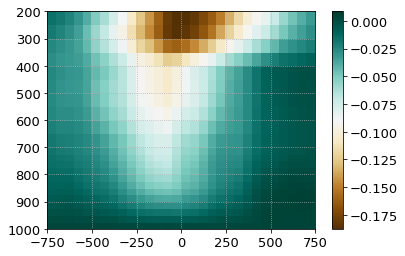

In [72]:
tt = 22
t_stats = ttest_ind(omega_cross_all[idx_G5,tt,:,:],0*omega_cross_all[idx_G5,tt,:,:],axis=0)
qv1pval = t_stats.pvalue
test1 = np.copy(omega_r5[tt,:,:])
test1[qv1pval>0.05] = np.nan # significance map

plt.pcolormesh(radius_bin[:],lev,omega_r5[tt,:,:],cmap='BrBG')
#            clim=(-0.5, 1.5),norm=MidpointNormalize(midpoint=0,vmin=-0.5, vmax=1.5))
plt.ylim([1000,200])
plt.colorbar()
# plt.contour(radius_bin[:-1],lev,-test1[:,:].T*1e7
#             ,levels=[-0.4,-0.2,0.2,0.4,0.6,0.8,1],colors=['k'],linewidths=1)
plt.grid(linestyle=':')

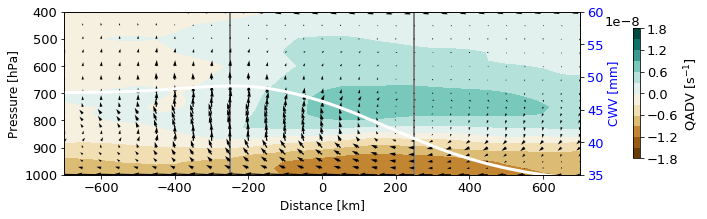

In [196]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
levs = np.linspace(-1.8,1.8,13)*1e-8
cf1=ax.contourf(radius_bin[:],lev,qadv_r1[22,:,:],cmap='BrBG',levels = levs,
               clim=(-1.8e-8, 1.8e-8),norm=MidpointNormalize(midpoint=0,vmin=-1.8e-8, vmax=1.8e-8))
cbar1 = plt.colorbar(cf1,ax=ax,pad=0.08,shrink=0.8); cbar1.set_label('QADV [s$^{-1}$]')
ax.quiver(radius_bin[:],lev,v_r1[24,:,:],-50*omega_r1[22,:,:],zorder=2)
ax2 = ax.twinx();ax2.tick_params(axis='y', labelcolor='b')
ax2.plot(radius_bin[:],cwv_cross_all[idx_G1,24,:].mean(axis=0),'white',linewidth=3)
ax.set_ylim([1000,400]);ax2.set_ylim([35,60])
ax.set_xlim([-700,700])
ax.set_xlabel('Distance [km]',fontsize=12);ax.set_ylabel('Pressure [hPa]',fontsize=12)
ax2.set_ylabel('CWV [mm]',fontsize=12,color='b')
ax.vlines(x=-250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)
ax.vlines(x=250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)

#fig.savefig(fig_dir+'QADV_crosssect_G1.pdf',bbox_inches='tight')

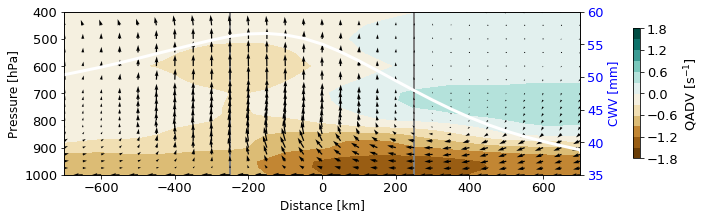

In [197]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
levs = np.linspace(-1.8,1.8,13)
cf1=ax.contourf(radius_bin[:],lev,1e8*qadv_r3[22,:,:],cmap='BrBG',levels = levs,
               clim=(-1.8, 1.8),norm=MidpointNormalize(midpoint=0,vmin=-1.8, vmax=1.8))
cbar1 = plt.colorbar(cf1,ax=ax,pad=0.08,shrink=0.8); cbar1.set_label('QADV [s$^{-1}$]')
ax.quiver(radius_bin[:],lev,v_r3[22,:,:],-50*omega_r3[22,:,:],zorder=2)
ax2 = ax.twinx();ax2.tick_params(axis='y', labelcolor='b')
ax2.plot(radius_bin[:],cwv_cross_all[idx_G3,24,:].mean(axis=0),'w',linewidth=3)
ax.set_ylim([1000,400]);ax2.set_ylim([35,60])
ax.set_xlim([-700,700])
ax.set_xlabel('Distance [km]',fontsize=12);ax.set_ylabel('Pressure [hPa]',fontsize=12)
ax2.set_ylabel('CWV [mm]',fontsize=12,color='b')
ax.vlines(x=-250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)
ax.vlines(x=250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)

#fig.savefig(fig_dir+'QADV_crosssect_G3.pdf',bbox_inches='tight')

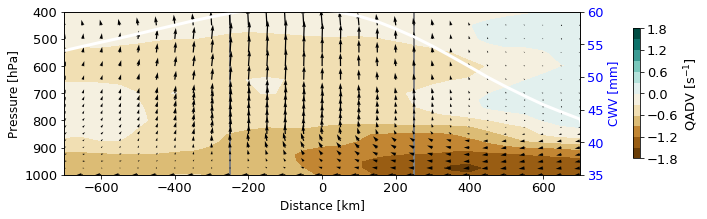

In [115]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
levs = np.linspace(-1.8,1.8,13)
cf1=ax.contourf(radius_bin[:],lev,1e8*qadv_r5[22,:,:],cmap='BrBG',levels = levs,
               clim=(-1.8, 1.8),norm=MidpointNormalize(midpoint=0,vmin=-1.8, vmax=1.8))
cbar1 = plt.colorbar(cf1,ax=ax,pad=0.08,shrink=0.8); cbar1.set_label('QADV [s$^{-1}$]')
ax.quiver(radius_bin[:],lev,v_r5[22,:,:],-50*omega_r5[22,:,:],zorder=2)
ax2 = ax.twinx();ax2.tick_params(axis='y', labelcolor='b')
ax2.plot(radius_bin[:],cwv_cross_all[idx_G5,22,:].mean(axis=0),'w',linewidth=3)
ax.set_ylim([1000,400]);ax2.set_ylim([35,60])
ax.set_xlim([-700,700])
ax.set_xlabel('Distance [km]',fontsize=12);ax.set_ylabel('Pressure [hPa]',fontsize=12)
ax2.set_ylabel('CWV [mm]',fontsize=12,color='b')
ax.vlines(x=-250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)
ax.vlines(x=250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)

#fig.savefig(fig_dir+'QADV_crosssect_G5.pdf',bbox_inches='tight')

In [87]:
def crosssect_vars_plot(var_cross_all, t = [20,24,28]):
    
    fig,ax = plt.subplots(1,len(t),figsize=(10,3))
    
    for n,tt in enumerate(t):
        t_stats = ttest_ind(var_cross_all[:,tt,:,:],0*qvflx_radius_all[:,tt,:,:],axis=0)
        qv1pval = t_stats.pvalue
        test1 = np.copy(np.nanmean(var_cross_all,axis=0)[tt,:,:])
        test1[qv1pval>0.05] = np.nan # significance map

        ax[n].pcolormesh(radius_bin[:],lev,test1[:,:]*1e7,cmap='BrBG',
            clim=(-0.5, 1.5),norm=MidpointNormalize(midpoint=0,vmin=-0.5, vmax=1.5))
        ax[n].set_ylim([1000,200])
        #cbar1=plt.colorbar()
        ax[n].contour(radius_bin[:],lev,-test1[:,:]*1e7
            ,levels=[-0.4,-0.2,0.2,0.4,0.6,0.8,1],colors=['k'],linewidths=1)  
    

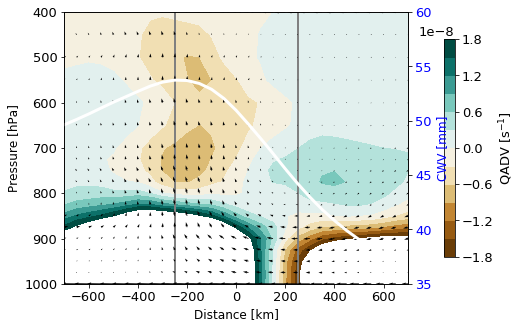

In [251]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
levs = np.linspace(-1.8,1.8,13)*1e-8
cf1=ax.contourf(radius_bin[:],lev,qvflx_r2[24,:,:],cmap='BrBG',levels = levs,
               clim=(-1.8e-8, 1.8e-8),norm=MidpointNormalize(midpoint=0,vmin=-1.8e-8, vmax=1.8e-8))
cbar1 = plt.colorbar(cf1,ax=ax,pad=0.08,shrink=0.8); cbar1.set_label('QADV [s$^{-1}$]')
ax.quiver(radius_bin[:],lev,v_r2[24,:,:],-20*omega_r2[24,:,:],zorder=2)
ax2 = ax.twinx();ax2.tick_params(axis='y', labelcolor='b')
ax2.plot(radius_bin[:],cwv_cross_all[idx_G2,24,:].mean(axis=0),'white',linewidth=3)
ax.set_ylim([1000,400]);ax2.set_ylim([35,60])
ax.set_xlim([-700,700])
ax.set_xlabel('Distance [km]',fontsize=12);ax.set_ylabel('Pressure [hPa]',fontsize=12)
ax2.set_ylabel('CWV [mm]',fontsize=12,color='b')
ax.vlines(x=-250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)
ax.vlines(x=250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)

#fig.savefig(fig_dir+'QADV_crosssect_G1.pdf',bbox_inches='tight')

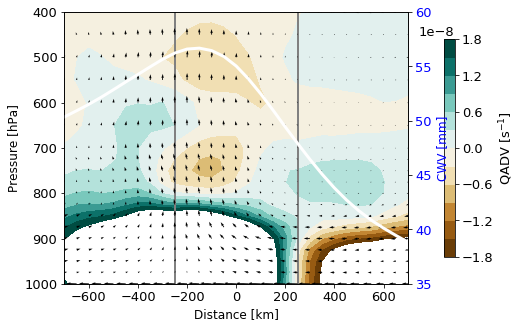

In [250]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
levs = np.linspace(-1.8,1.8,13)*1e-8
cf1=ax.contourf(radius_bin[:],lev,qvflx_r3[24,:,:],cmap='BrBG',levels = levs,
               clim=(-1.8e-8, 1.8e-8),norm=MidpointNormalize(midpoint=0,vmin=-1.8e-8, vmax=1.8e-8))
cbar1 = plt.colorbar(cf1,ax=ax,pad=0.08,shrink=0.8); cbar1.set_label('QADV [s$^{-1}$]')
ax.quiver(radius_bin[:],lev,v_r3[24,:,:],-20*omega_r3[24,:,:],zorder=2)
ax2 = ax.twinx();ax2.tick_params(axis='y', labelcolor='b')
ax2.plot(radius_bin[:],cwv_cross_all[idx_G3,24,:].mean(axis=0),'white',linewidth=3)
ax.set_ylim([1000,400]);ax2.set_ylim([35,60])
ax.set_xlim([-700,700])
ax.set_xlabel('Distance [km]',fontsize=12);ax.set_ylabel('Pressure [hPa]',fontsize=12)
ax2.set_ylabel('CWV [mm]',fontsize=12,color='b')
ax.vlines(x=-250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)
ax.vlines(x=250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)

#fig.savefig(fig_dir+'QADV_crosssect_G1.pdf',bbox_inches='tight')

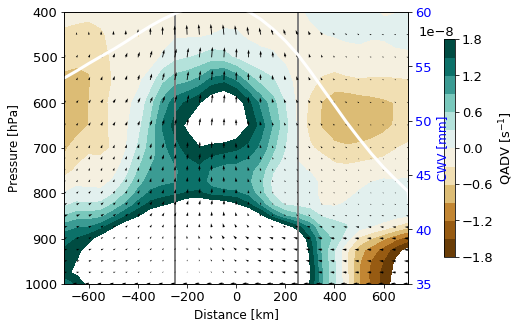

In [248]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
levs = np.linspace(-1.8,1.8,13)*1e-8
cf1=ax.contourf(radius_bin[:],lev,qvflx_r5[24,:,:],cmap='BrBG',levels = levs,
               clim=(-1.8e-8, 1.8e-8),norm=MidpointNormalize(midpoint=0,vmin=-1.8e-8, vmax=1.8e-8))
cbar1 = plt.colorbar(cf1,ax=ax,pad=0.08,shrink=0.8); cbar1.set_label('QADV [s$^{-1}$]')
ax.quiver(radius_bin[:],lev,v_r5[24,:,:],-20*omega_r5[24,:,:],zorder=2)
ax2 = ax.twinx();ax2.tick_params(axis='y', labelcolor='b')
ax2.plot(radius_bin[:],cwv_cross_all[idx_G5,24,:].mean(axis=0),'white',linewidth=3)
ax.set_ylim([1000,400]);ax2.set_ylim([35,60])
ax.set_xlim([-700,700])
ax.set_xlabel('Distance [km]',fontsize=12);ax.set_ylabel('Pressure [hPa]',fontsize=12)
ax2.set_ylabel('CWV [mm]',fontsize=12,color='b')
ax.vlines(x=-250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)
ax.vlines(x=250,ymin=400,ymax=1000,linewidth=2,color='grey',zorder=1)

(-2.5, 1)

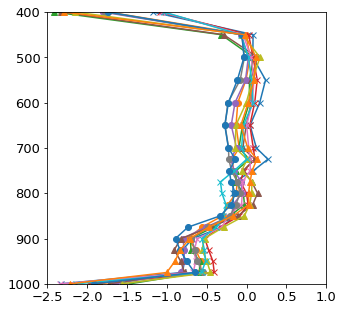

In [245]:
tt=[24,26,28,30]
fig,ax = plt.subplots(1,1,figsize=(5,5))
for t in tt:
    cf1=ax.plot(v_r1[t,:,15],lev,'-x')
    ax.plot(v_r3[t,:,15],lev,'-o')
    ax.plot(v_r5[t,:,15],lev,'-^')    
plt.ylim([1000,400]);plt.xlim([-2.5,1])

####  successive events after different scale of convection formation

In [ ]:
def var_successive(idx_group,succ_num,var_all):
    var_com = np.zeros((len(idx_group),succ_num)) # variable stored
    days_com = np.copy(var_com)
    for n,idx in enumerate(idx_group):

        target_time = time_event[idx]
        target_lat = lat_event[idx]
        target_lon = lon_event[idx]

        idx1 = np.where(lat_event == target_lat)
        idx2 = np.where(lon_event == target_lon)
        idx_pos = np.intersect1d(idx1,idx2)

        for i,idy in enumerate(idx_pos):
            if target_time == time_event[idy]:
                idx_succ = idx_pos[i:i+succ_num]
                var_com[n,:len(idx_succ)] = var_all[idx_succ,24]
                for t in range(len(idx_succ)-1):
                    days_com[n,:len(idx_succ)] = (time_event[idx_succ[t+1]]-time_event[idx_succ[t]]).days
                
    return var_com, days_com

In [ ]:
cldfrac_succG1,days_succG1 = var_successive(idx_G1,2,cldfrac_all)
cldfrac_succG2,days_succG2 = var_successive(idx_G2,2,cldfrac_all)
cldfrac_succG3,days_succG3 = var_successive(idx_G3,2,cldfrac_all)
cldfrac_succG4,days_succG4 = var_successive(idx_G4,2,cldfrac_all)
cldfrac_succG5,days_succG5 = var_successive(idx_G5,2,cldfrac_all)

# plt.plot(np.nanmean(cldfrac_succG1,axis=0),'-or')
# plt.plot(np.nanmean(cldfrac_succG2,axis=0),'-og')
# plt.plot(np.nanmean(cldfrac_succG3,axis=0),'-ob')
# plt.plot(np.nanmean(cldfrac_succG4,axis=0),'-om')
# plt.plot(np.nanmean(cldfrac_succG5,axis=0),'-ok')

In [ ]:
days_succG1

In [ ]:
cldfrac_bin = np.linspace(0,1,21)
num_cldfrac = np.zeros((5,len(cldfrac_bin)-1))

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_succG1[:,1]>=cldfrac_bin[n]
                                  , cldfrac_succG1[:,1]<cldfrac_bin[n+1]))[0]
    num_cldfrac[0,n] = len(idx)
for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_succG2[:,1]>=cldfrac_bin[n]
                                  , cldfrac_succG2[:,1]<cldfrac_bin[n+1]))[0]
    num_cldfrac[1,n] = len(idx)
for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_succG3[:,1]>=cldfrac_bin[n]
                                  , cldfrac_succG3[:,1]<cldfrac_bin[n+1]))[0]
    num_cldfrac[2,n] = len(idx)
for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_succG4[:,1]>=cldfrac_bin[n]
                                  , cldfrac_succG4[:,1]<cldfrac_bin[n+1]))[0]
    num_cldfrac[3,n] = len(idx)
for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_succG5[:,1]>=cldfrac_bin[n]
                                  , cldfrac_succG5[:,1]<cldfrac_bin[n+1]))[0]
    num_cldfrac[4,n] = len(idx)

In [ ]:
colors=['k','r','g','b','m']
for n in range(5):
    plt.plot(cldfrac_bin[:-1],num_cldfrac[n,:]/np.sum(num_cldfrac[n,:]),color=colors[n])

#### CWV-P relationship

In [ ]:
cldfrac_bin = np.array([0,0.1,0.2,0.5,1]) # mm/day
crhcom_bin = np.zeros((len(cldfrac_bin)-1,49))
preccom_crh_bin = np.copy(crhcom_bin)
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>= cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    crhcom_bin[n,:] = np.nanmean(crh_all[idx,:],axis=0)
    preccom_crh_bin[n,:] = np.nanmean(prec_all[idx,:],axis=0)
    num_bin[n] = len(idx)

In [ ]:
cldfrac_bin = np.array([0,0.1,0.2,0.5,1]) # mm/day
cwvcom_bin = np.zeros((len(cldfrac_bin)-1,49))
preccom_cwv_bin = np.copy(cwvcom_bin)
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>= cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cwvcom_bin[n,:] = np.nanmean(cwv_all[idx,:],axis=0)
    preccom_cwv_bin[n,:] = np.nanmean(prec_all[idx,:],axis=0)
    num_bin[n] = len(idx)

In [ ]:
# SSMI/daily 2018 P-RH relation 
pr=6.89e-5 # mm/day
ad=14.72   

crh_range = np.linspace(0.3,0.9,50,dtype='float32')
P_est_R2018_all = pr*np.exp(ad*crh_range)/24
P_est_B2004_all = np.exp(11.4*(crh_range-0.522))/24

In [ ]:
cwv_array = np.linspace(40,65,25)
crh_array = np.linspace(0.5,0.9,25)
prec_cwv = np.zeros(len(cwv_array)-1)
prec_crh = np.zeros(len(crh_array)-1)

for i in range(len(cwv_array)-1):
    idx = np.where(np.logical_and(cwv_all.ravel()>=cwv_array[i],cwv_all.ravel()<cwv_array[i+1]))[0]
    prec_cwv[i] = np.nanmean(prec_all.ravel()[idx])
    
for i in range(len(crh_array)-1):
    idx = np.where(np.logical_and(crh_all.ravel()>=crh_array[i],crh_all.ravel()<crh_array[i+1]))[0]
    prec_crh[i] = np.nanmean(prec_all.ravel()[idx])

In [ ]:
crh_samp = crh_all.ravel()
prec_samp = prec_all.ravel()

crh_re = crh_samp[np.where(~np.isnan(crh_samp))[0]]
prec_re = prec_samp[np.where(~np.isnan(crh_samp))[0]]
# remove non-precip 
prec_re2 = prec_re[np.where(prec_re>0)[0]]
crh_re2 = crh_re[np.where(prec_re>0)[0]]

c = np.polyfit(crh_re2,np.log(prec_re2),1)

prec_clim = np.exp(c[0]*crh_range+c[1])

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(crhcom_bin[0,:],preccom_crh_bin[0,:],'-om',markerfacecolor='None')
ax[0].plot(crhcom_bin[1,:],preccom_crh_bin[1,:],'-og',markerfacecolor='None')
ax[0].plot(crhcom_bin[2,:],preccom_crh_bin[2,:],'-ob',markerfacecolor='None')
ax[0].plot(crhcom_bin[3,:],preccom_crh_bin[3,:],'-oy',markerfacecolor='None')
ax[0].plot(crh_array[:-1],prec_crh,'-k',linewidth=2.5)
ax[0].set_xlabel('Column relative humidity',fontsize=14)
ax[0].set_ylabel('Precipitation [mm/hr]',fontsize=14)
ax[0].set_xlim([0.55,0.85]);ax[0].set_ylim([-0.06,2.2])
ax[0].legend(['0-0.1','0.1-0.25','0.25-0.5','>0.5','CLIM'])
ax[0].grid(linestyle='--')
ax[0].tick_params(labelsize=13)

ax[1].plot(cwvcom_bin[0,:],preccom_cwv_bin[0,:],'-om',markerfacecolor='None')
ax[1].plot(cwvcom_bin[1,:],preccom_cwv_bin[1,:],'-og',markerfacecolor='None')
ax[1].plot(cwvcom_bin[2,:],preccom_cwv_bin[2,:],'-ob',markerfacecolor='None')
ax[1].plot(cwvcom_bin[3,:],preccom_cwv_bin[3,:],'-oy',markerfacecolor='None')
ax[1].plot(cwv_array[:-1],prec_cwv,'-k',linewidth=2.5)
ax[1].set_xlabel('Column water vapor [mm]',fontsize=14)
ax[1].set_ylabel('Precipitation [mm/hr]',fontsize=14)
ax[1].set_xlim([42,60]);plt.ylim([-0.06,2.2])
ax[1].legend(['0-0.1','0.1-0.25','0.25-0.5','>0.5','CLIM'])
ax[1].grid(linestyle='--')
ax[1].tick_params(labelsize=13)

In [ ]:
from scipy.ndimage import gaussian_filter

### Omega vertical mode decomposition [Masunaga and L'ecuyer]

In [ ]:
def vertmode_omega(omega_data,omega_bg,fbc_mtx):
    'omega_bg: background omega profile'
    m_dim = fbc_mtx.shape[0]
    t_dim = omega_data.shape[0]
    m_time = np.zeros((m_dim,t_dim))
    omega_rcst = np.zeros(omega_data.shape) # reconstructed profile by three modes 
    for t in range(t_dim):
        omega_mtx = np.matrix((omega_data[t,:25]-omega_bg[:25]))
        m_mtx = (fbc_mtx*fbc_mtx.T).I*(fbc_mtx*omega_mtx.T) # regression coefficient    
        m_time[:,t] = m_mtx.A.T
        omega_rcst[t,:] = m_mtx.T*fbc_mtx
    return m_time, omega_rcst

In [ ]:
# prescribed vertical mode definition
ps = 1000
ptp = 100
p = lev[:25]
fbc1 = -np.sin(1*np.pi*(p-ptp)/(ps-ptp)) # prescribed first mode
fbc2 = -np.sin(2*np.pi*(p-ptp)/(ps-ptp)) # prescribed second mode 
fshl = -np.sin(np.pi*(p-800)/(ps-800)); fshl[8:] = 0 # prescribed shallow mode, peak at 900hpa
fbc_mtx = np.stack((fbc1,fbc2,fshl),axis=0)
fbc_mtx = np.matrix(fbc_mtx)

In [ ]:
fig = plt.figure(figsize=(5,4.5))
plt.plot(fbc1,p,'-k',linewidth=2,alpha=0.8)
plt.plot(fbc2,p,'--k',linewidth=2,alpha=0.8)
plt.plot(fshl,p,':k',linewidth=2,alpha=0.8)
plt.ylim([1000,100]);plt.vlines(x=0,ymax=1000,ymin=100,linewidth=0.5)
plt.legend(['F$_1$, dc','F$_2$, st','F$_3$, cu'],fontsize=12,frameon=False)
plt.ylabel('Pressure [hPa]',fontsize=12)

In [ ]:
fig.savefig(fig_dir+'Verticalmode_functions.pdf',bbox_inches='tight')

In [ ]:
omega_allmn = np.nanmean(omega_all,axis=0)
omega_bg = np.nanmean(np.concatenate((omega_allmn[:4,:25],omega_allmn[-4:,:25])),axis=0)

In [ ]:
em1_time = np.zeros(prec_all.shape)
em2_time = np.zeros(prec_all.shape)
em3_time = np.zeros(prec_all.shape)

for n in range(len(omega_all)):
    m_time, omega_rcst = vertmode_omega(omega_all[n,:,:25],omega_bg,fbc_mtx)
    em1_time[n,:] = m_time[0,:]
    em2_time[n,:] = m_time[1,:]
    em3_time[n,:] = m_time[2,:]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),np.nanmean(em1_time,axis=0)/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),np.nanmean(em2_time,axis=0)/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),np.nanmean(em3_time,axis=0)/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.ylim([-1,3]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)
fig.savefig(fig_dir+'vertmode_coeff_allevents.pdf',bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_dc_all,axis=0),'-k')
plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_st_all,axis=0),'--k')
plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_cu_all,axis=0),':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,25]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)
fig.savefig(fig_dir+'vertmode_cldamt_allevents.pdf',bbox_inches='tight')

In [ ]:
em1_g1 = np.nanmean(em1_time[idx_G1,:],axis=0)
em2_g1 = np.nanmean(em2_time[idx_G1,:],axis=0)
em3_g1 = np.nanmean(em3_time[idx_G1,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g1/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g1/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g1/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
cuamt_g1 = np.nanmean(cldamt_cu_all[idx_G1,:],axis=0)
stamt_g1 = np.nanmean(cldamt_st_all[idx_G1,:],axis=0)
dcamt_g1 = np.nanmean(cldamt_dc_all[idx_G1,:],axis=0)
toamt_g1 = cuamt1+stamt1+dcamt1

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),dcamt_g1,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g1,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g1,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,15]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
em1_g3 = np.nanmean(em1_time[idx_G3,:],axis=0)
em2_g3 = np.nanmean(em2_time[idx_G3,:],axis=0)
em3_g3 = np.nanmean(em3_time[idx_G3,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g3/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g3/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g3/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
cuamt_g3 = np.nanmean(cldamt_cu_all[idx_G3,:],axis=0)
stamt_g3 = np.nanmean(cldamt_st_all[idx_G3,:],axis=0)
dcamt_g3 = np.nanmean(cldamt_dc_all[idx_G3,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),dcamt_g3,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g3,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g3,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,30]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
em1_g5 = np.nanmean(em1_time[idx_G5,:],axis=0)
em2_g5 = np.nanmean(em2_time[idx_G5,:],axis=0)
em3_g5 = np.nanmean(em3_time[idx_G5,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g5/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g5/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g5/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
cuamt_g5 = np.nanmean(cldamt_cu_all[idx_G5,:],axis=0)
stamt_g5 = np.nanmean(cldamt_st_all[idx_G5,:],axis=0)
dcamt_g5 = np.nanmean(cldamt_dc_all[idx_G5,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),dcamt_g5,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g5,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g5,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,45]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
cuamt_g2 = np.nanmean(cldamt_cu_all[idx_G2,:],axis=0)
stamt_g2 = np.nanmean(cldamt_st_all[idx_G2,:],axis=0)
dcamt_g2 = np.nanmean(cldamt_dc_all[idx_G2,:],axis=0)

em1_g2 = np.nanmean(em1_time[idx_G2,:],axis=0)
em2_g2 = np.nanmean(em2_time[idx_G2,:],axis=0)
em3_g2 = np.nanmean(em3_time[idx_G2,:],axis=0)

cuamt_g4 = np.nanmean(cldamt_cu_all[idx_G4,:],axis=0)
stamt_g4 = np.nanmean(cldamt_st_all[idx_G4,:],axis=0)
dcamt_g4 = np.nanmean(cldamt_dc_all[idx_G4,:],axis=0)

em1_g4 = np.nanmean(em1_time[idx_G4,:],axis=0)
em2_g4 = np.nanmean(em2_time[idx_G4,:],axis=0)
em3_g4 = np.nanmean(em3_time[idx_G4,:],axis=0)

cuamt_g6 = np.nanmean(cldamt_cu_all,axis=0)
stamt_g6 = np.nanmean(cldamt_st_all,axis=0)
dcamt_g6 = np.nanmean(cldamt_dc_all,axis=0)

em1_g6 = np.nanmean(em1_time,axis=0)
em2_g6 = np.nanmean(em2_time,axis=0)
em3_g6 = np.nanmean(em3_time,axis=0)

In [ ]:
re_stats = np.zeros((6,3,2))
re_stats[0,0,:] = np.asarray(pearsonr(em1_g1,dcamt_g1))
re_stats[0,1,:] = np.asarray(pearsonr(em2_g1,stamt_g1))    
re_stats[0,2,:] = np.asarray(pearsonr(em3_g1,cuamt_g1))    
re_stats[1,0,:] = np.asarray(pearsonr(em1_g2,dcamt_g2))    
re_stats[1,1,:] = np.asarray(pearsonr(em2_g2,stamt_g2))    
re_stats[1,2,:] = np.asarray(pearsonr(em3_g2,cuamt_g2))    
re_stats[2,0,:] = np.asarray(pearsonr(em1_g3,dcamt_g3))    
re_stats[2,1,:] = np.asarray(pearsonr(em2_g3,stamt_g3))    
re_stats[2,2,:] = np.asarray(pearsonr(em3_g3,cuamt_g3))    
re_stats[3,0,:] = np.asarray(pearsonr(em1_g4,dcamt_g4))    
re_stats[3,1,:] = np.asarray(pearsonr(em2_g4,stamt_g4))    
re_stats[3,2,:] = np.asarray(pearsonr(em3_g4,cuamt_g4))    
re_stats[4,0,:] = np.asarray(pearsonr(em1_g5,dcamt_g5))    
re_stats[4,1,:] = np.asarray(pearsonr(em2_g5,stamt_g5))    
re_stats[4,2,:] = np.asarray(pearsonr(em3_g5,cuamt_g5)) 
re_stats[5,0,:] = np.asarray(pearsonr(em1_g6,dcamt_g6))    
re_stats[5,1,:] = np.asarray(pearsonr(em2_g6,stamt_g6))    
re_stats[5,2,:] = np.asarray(pearsonr(em3_g6,cuamt_g6))  #    np.corrcoef(em3_g5,cuamt_g5)[0,1]

In [ ]:
import pandas as pd

In [ ]:
d = {'coeff_m1': re_stats[:,0,0],'p_m1': re_stats[:,0,1],
     'coeff_m2': re_stats[:,1,0],'p_m2': re_stats[:,1,1],
     'coeff_m3': re_stats[:,2,0],'p_m3': re_stats[:,2,1]}
df = pd.DataFrame(data = d)

In [ ]:
df

In [ ]:
colors = ['k','r','g','b','m']
symbals = ['x','o','^','d','s']
for n in range(5):
    plt.plot(range(3),re_stats[n,:,0],linestyle='',
             color=colors[n],marker=symbals[n],markersize=10)
plt.ylim([-1.2,1.2])

In [ ]:
fig = plt.figure(figsize=(12,3))
clevs=np.linspace(-0.09,0.015,15)*3600/100
plt.contourf(np.linspace(-72,72,49),lev,3600/100*np.nanmean(omega_all,axis=0).T,levels=clevs,
            cmap='RdBu_r',clim=(-0.09*36,0.015*36),norm=MidpointNormalize(midpoint=0,vmin=-0.09*36, vmax=0.015*36))
plt.ylim([1000,100]);cbar = plt.colorbar(pad=0.02,shrink=0.8)
cbar.set_label('[hPa/hr]')
plt.ylabel('Pressure [hPa]');plt.xlabel('hour')
fig.savefig(fig_dir+'omega_profile_exp.pdf',bbox_inches='tight')

(0, 1)

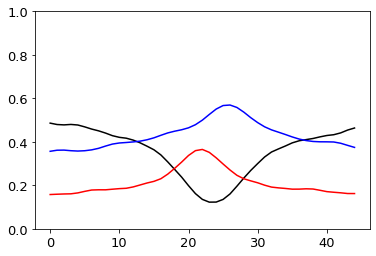

In [223]:
cuamt3 = np.nanmean(cldamt_cu_all[idx_G3,:],axis=0)
stamt3 = np.nanmean(cldamt_st_all[idx_G3,:],axis=0)
dcamt3 = np.nanmean(cldamt_dc_all[idx_G3,:],axis=0)
toamt3 = cuamt3+stamt3+dcamt3

plt.plot(np.convolve(cuamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'k')
plt.plot(np.convolve(stamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'b')
plt.plot(np.convolve(dcamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'r')
plt.ylim([0,1])

In [ ]:
cuamt5 = np.nanmean(cldamt_cu_all[idx_G5,:],axis=0)
stamt5 = np.nanmean(cldamt_st_all[idx_G5,:],axis=0)
dcamt5 = np.nanmean(cldamt_dc_all[idx_G5,:],axis=0)
toamt5 = cuamt5+stamt5+dcamt5

plt.plot(np.convolve(cuamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'k')
plt.plot(np.convolve(stamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'b')
plt.plot(np.convolve(dcamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'r')
plt.ylim([0,1])

In [ ]:
-----------------------------------------------

In [168]:
def caseview(time_event,lat_event,lon_event):

    data_sub1 = subset_MERRA2(MERRA2_3d_dir+'TQUV_3hr'
                          ,time_event,lat_event,lon_event,3,10,20)
    data_sub2 = subset_TRMM(TRMM_dir+'2014_2018'
                          ,time_event,lat_event,lon_event,3,10,20)
    data_sub3 = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event,lat_event,lon_event,3,10,20)
    data_sub4 = subset_MERRA2(MERRA2_3d_dir+'omega_3hr'
                          ,time_event,lat_event,lon_event,3,10,20)
    data_sub5 = subset_gridsat(Gridsat_dir+'2014_2018'
                          ,time_event,lat_event,lon_event,3,10,20)
    
    u_sm = data_sub1.U
    v_sm = data_sub1.V
    T_sm = data_sub1.T
    q_sm = data_sub1.QV
    prec_sm = data_sub2.precipitation.resample(time='6H').nearest()
    cwv_sm = data_sub3.TQV.resample(time='6H').nearest()
    omega_sm = data_sub4.OMEGA
    bt_sm = data_sub5.irwin_cdr.resample(time='6H').nearest()

    u_950sm = u_sm.sel(lev=950).resample(time='6H').nearest()
    v_950sm = v_sm.sel(lev=950).resample(time='6H').nearest()
    u_tar = u_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    v_tar = v_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    omega_tar = omega_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    prec_tar = prec_sm.sel(nlon=slice(lon_event-5,lon_event+5),nlat=slice(lat_event-5,lat_event+5))
    bt_tar = bt_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    SCAIbt_sm,SCAI_p,Nbt_sm,N_prec = SCAI_index(prec_tar,bt_tar) # 6H data
    div_tar = np.gradient(u_tar,0.625*100*1e3,axis=3)+np.gradient(v_tar,0.5*100*1e3,axis=2) # divergence 3D
    
    p = T_sm.lev.values*units('mbar')
    T_tar = T_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    q_tar = q_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    # cape/cin calculation
    cape_sm = np.zeros(len(T_tar.time))
    cin_sm = np.copy(cape_sm)
    for t in range(len(u_tar.time)):
        T_tmp = np.nanmean(T_tar[t,:,:,:],axis=(1,2))
        q_tmp = np.nanmean(q_tar[t,:,:,:],axis=(1,2))
        T = (T_tmp-273.15)*units('degC')
        q = q_tmp*units('kg/kg')
        Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q))
        
        try:
            Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC')                    
            el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
            el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))                
            ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
            [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
            cape_sm[t] = CAPE.magnitude
            cin_sm[t] = CIN.magnitude
        except:
            cape_sm[t] = np.nan
            cin_sm[t] = np.nan
    
    # Abar calculation
    tmp = bt_tar.values
    cldfrac_sm = [len(np.where(tmp[n,:,:]<240)[0])/(tmp.shape[1]*tmp.shape[2]) for n in range(tmp.shape[0])]
    Abar_sm = cldfrac_sm/Nbt_sm*1600
    
    return (u_950sm,v_950sm,omega_sm,prec_sm,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm
            ,div_tar,cape_sm,cin_sm)

In [183]:
idx_G1[4000:4100]

array([16888, 16890, 16892, 16894, 16896, 16897, 16898, 16899, 16900,
       16905, 16907, 16908, 16910, 16916, 16917, 16918, 16919, 16923,
       16927, 16934, 16939, 16941, 16942, 16950, 16951, 16952, 16956,
       16958, 16961, 16962, 16963, 16971, 16972, 16973, 16974, 16976,
       16984, 16990, 16995, 16996, 16997, 16998, 16999, 17000, 17003,
       17008, 17010, 17011, 17012, 17015, 17016, 17018, 17024, 17025,
       17026, 17027, 17031, 17032, 17047, 17048, 17051, 17052, 17053,
       17055, 17056, 17061, 17063, 17064, 17071, 17073, 17074, 17079,
       17080, 17081, 17082, 17083, 17084, 17085, 17086, 17087, 17091,
       17092, 17098, 17100, 17110, 17113, 17114, 17115, 17116, 17121,
       17122, 17123, 17130, 17131, 17132, 17133, 17134, 17135, 17136,
       17138])

In [184]:
num=16890
u_950sm,v_950sm,omega_sm,prec_sm,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm,div_sm,cape_sm,cin_sm = caseview(time_event[num],lat_event[num],lon_event[num])

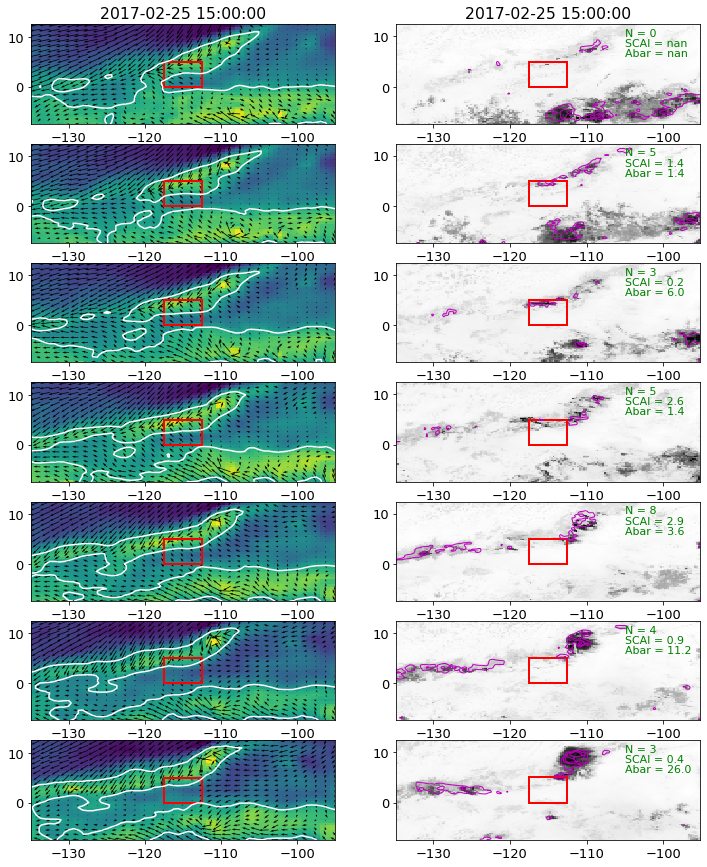

In [185]:
fig,ax = plt.subplots(7,2,figsize=(12,15))

label = np.arange(0,7)
timelabel = np.array([11,12,13,14,15,16,17])

for n,t in zip(label,timelabel):
    #ax[n] = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax[n,0].pcolormesh(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:])
    ax[n,0].contour(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:],levels=[45],colors=['w'])
    ax[n,0].quiver(u_950sm.lon[::2],u_950sm.lat[::2],u_950sm[t,::2,::2],v_950sm[t,::2,::2])      
    rect1 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None')
    ax[n,0].add_patch(rect1)
    if n ==0:
        ax[n,0].set_title(time_event[num])
        
    ax[n,1].contour(prec_sm.nlon,prec_sm.nlat,prec_sm[t,:,:].transpose(),
                   levels=[1,5,10,30,50],linewidths=1,colors=['m'])
    tmp = bt_sm[t,:,:].values; #tmp[tmp>240] = np.nan
    ax[n,1].pcolormesh(bt_sm.lon,bt_sm.lat,tmp,cmap='binary_r') 
    rect2 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None')
    ax[n,1].add_patch(rect2)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+7.5,'N = '+str(int(Nbt_sm[t])),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+5.5,'SCAI = '+str(round(SCAIbt_sm[t],1)),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+3.5,'Abar = '+str(round(Abar_sm[t],1)),color='g',fontsize=11)
    if n ==0:
        ax[n,1].set_title(time_event[num])

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
SFX_bin = np.zeros((len(cldfrac_bin)-1,48)) # m/s
SFXstd_bin = np.zeros((len(cldfrac_bin)-1,48))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    SFX_bin[n,:] = np.nanmean(SFX_all[idx,:],axis=0)
    SFXstd_bin[n,:] = np.nanmean(SFXstd_all[idx,:],axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('SFX [W/m$^2$]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle=':')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
wsfc_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    wsfc_bin[n,:] = np.nanmean((u_all[idx,:,0]**2+v_all[idx,:,0]**2)**0.5,axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('SFX [W/m$^2$]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle=':')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
# cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
# freq_bin = np.zeros((len(cldfrac_bin)-1,4)) # m/s

# for n in range(len(cldfrac_bin)-1):
#     idx1 = np.where(np.logical_and(cldfrac_DJF[:,24]>=cldfrac_bin[n],cldfrac_DJF[:,24]<cldfrac_bin[n+1]))[0]
#     idx2 = np.where(np.logical_and(cldfrac_MAM[:,24]>=cldfrac_bin[n],cldfrac_MAM[:,24]<cldfrac_bin[n+1]))[0]
#     idx3 = np.where(np.logical_and(cldfrac_JJA[:,24]>=cldfrac_bin[n],cldfrac_JJA[:,24]<cldfrac_bin[n+1]))[0]
#     idx4 = np.where(np.logical_and(cldfrac_SON[:,24]>=cldfrac_bin[n],cldfrac_SON[:,24]<cldfrac_bin[n+1]))[0]
    
#     freq_bin[n,0] = len(idx1)
#     freq_bin[n,1] = len(idx2)
#     freq_bin[n,2] = len(idx3)
#     freq_bin[n,3] = len(idx4)

In [ ]:
# constructing the climatology over targeted scenes for T,q,RH anomaly 
# to remove seasonality and diurnal cycle
os.chdir(MERRA2_dir+'inst_2d_hourly')
files = sorted(glob('*nc'))
data = xr.open_mfdataset(files)

In [ ]:
cwv = data.sel(lat=slice(-20,20)).TQV
cwv_clim = cwv.groupby('time.month').mean('time').compute() # climatology of daily data

In [ ]:
# test for removing seasonality over all cases
cwv_rmseason = np.copy(cwv_all)

for n in range(len(time_event)):
    cwv_climsub = cwv_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    cwv_rmseason[n,:] = cwv_all[n,:] - cwv_climsub.mean().values

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cwva_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cwvastd_bin = np.zeros((len(cldfrac_bin)-1,49))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cwva_bin[n,:] = np.nanmean(cwv_all[idx,:],axis=0)
    cwvastd_bin[n,:] = np.nanstd(cwv_all[idx,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)

fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('CWV anomaly [mm]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [ ]:
# prec anomaly vs cwv anomaly
fig = plt.figure(figsize=(6,6))

plt.plot(cwva_bin[0,:],preca_bin[0,:],'-k',linewidth=0.6)
plt.scatter(cwva_bin[0,:],preca_bin[0,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[1,:],preca_bin[1,:],'-r',linewidth=0.6)
plt.scatter(cwva_bin[1,:],preca_bin[1,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[2,:],preca_bin[2,:],'-g',linewidth=0.6)
plt.scatter(cwva_bin[2,:],preca_bin[2,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[3,:],preca_bin[3,:],'-b',linewidth=0.6)
plt.scatter(cwva_bin[3,:],preca_bin[3,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')

In [ ]:
# open T_clim, qv_clim, RH_clim 
os.chdir('/w2-data/willytsai/ISCCP/')
T_clim = xr.open_dataset('T_clim_10deg.nc')
qv_clim = xr.open_dataset('qv_clim_10deg.nc')
RH_clim = xr.open_dataset('rh_clim_10deg.nc')

In [ ]:
T_rmseason = np.copy(T_all)

for n in range(len(time_event)):
    T_climsub = T_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).T
    T_rmseason[n,:,:] = (T_all[n,:,:] - T_climsub.mean(axis=(1,2)).values)

In [ ]:
q_rmseason = np.copy(q_all)

for n in range(len(time_event)):
    q_climsub = qv_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).QV
    q_rmseason[n,:,:] = q_all[n,:,:] - q_climsub.mean(axis=(1,2)).values

In [ ]:
rh_rmseason = np.copy(rh_all)

for n in range(len(time_event)):
    rh_climsub = RH_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).RH
    rh_rmseason[n,:,:] = rh_all[n,:,:] - rh_climsub.mean(axis=(1,2)).values

In [ ]:
# os.chdir(MERRA2_3d_dir+'RH_3hr')
# files = glob('*nc4')
# data = xr.open_mfdataset(files)

In [ ]:
# %%time
# rh = data.sel(lon=slice(50,90),lat=slice(-10,10)).RH
# rh_clim = rh.groupby('time.month').mean('time').compute() # climatology of daily data

In [ ]:
# os.chdir('/w2-data/willytsai/ISCCP')
# m2data = np.loadtxt('MERRA2_modellevs.txt')
# m2lev = np.flipud(m2data[:,1])

In [ ]:
# for m in range(12):
#     plt.plot(np.nanmean(rh_clim[m,:,:,:],axis=(1,2)),m2lev,zorder=1)
# plt.ylim([1000,150])
# plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
for m in range(12):
    plt.plot(qv_clim[m,:,:,:].mean(axis=(1,2)),lev,zorder=1)
plt.ylim([1000,150])
plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
u = data.sel(lon=slice(50,90),lat=slice(-10,10)).U
u_clim = u.groupby('time.month').mean('time').compute() # climatology of daily data

u_rmseason = np.copy(u_all)

for n in range(len(time_event)):
    u_climsub = u_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    u_rmseason[n,:] = u_all[n,:,:] - u_climsub.mean(axis=(1,2)).values

In [ ]:
for m in range(12):
    plt.plot(u_clim[m,:,:,:].mean(axis=(1,2)),lev,zorder=1)
plt.ylim([1000,150]);plt.vlines(0,ymax=1000,ymin=0,zorder=2)
plt.xlim([-10,10])
plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
lev_model = np.loadtxt('MERRA2_modellevs.txt')[:,1]

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
rha_bin = np.zeros((len(cldfrac_bin)-1,49,72)) # m/s
rhastd_bin = np.zeros((len(cldfrac_bin)-1,49,72))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    rha_bin[n,:,:] = np.nanmean(rh_all[idx,:,:],axis=0)
    rhastd_bin[n,:,:] = np.nanstd(rh_all[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs = np.linspace(0.3,1,8)
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[0,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[1,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[2,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[3,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
qa_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
qastd_bin = np.zeros((len(cldfrac_bin)-1,49,42))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    qa_bin[n,:,:] = np.nanmean(q_rmseason[idx,:,:],axis=0)
    qastd_bin[n,:,:] = np.nanstd(q_rmseason[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs = np.linspace(-1,1,21)
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[0,:,:].T*1000,cmap='jet',
            levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[1,:,:].T*1000,cmap='jet',
            levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[2,:,:].T*1000,cmap='jet',
             levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[3,:,:].T*1000,cmap='jet',
             levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()

#plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
#          ,fontsize=9)
#plt.ylabel('CWV anomaly [mm]')
#plt.xlabel('Lag time [hr]')
#plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
Ta_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
Tastd_bin = np.zeros((len(cldfrac_bin)-1,49,42))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    Ta_bin[n,:,:] = np.nanmean(T_rmseason[idx,:,:],axis=0)
    Tastd_bin[n,:,:] = np.nanstd(T_rmseason[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs1 = np.linspace(-0.5,0.5,21)

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[0,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[0,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[1,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[1,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[2,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[2,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[3,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[3,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()


In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cape_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
capestd_bin = np.zeros((len(cldfrac_bin)-1,49))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cape_bin[n,:] = np.nanmean(cape_all[idx,:],axis=0)
    capestd_bin[n,:] = np.nanstd(cape_all[idx,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('CWV anomaly [mm]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
%%time
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # cldfrac at ref
div_regress = np.zeros((len(time_event),49,42))

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        for k in range(div_regress.shape[2]): # vertical dims
            tmp = prec_all[t,:];tmp2 = div_all[t,:,k]
            pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
            if len(pp) > 0: # not empty
                reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
                div_regress[t,:,k] = np.asarray(reg)
            else:
                div_regress[t,:,k] = np.nan

In [ ]:
# divergence evolution
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
div_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    div_bin[n,:,:] = np.nanmean(div_regress[idx,:,:],axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))
clevs = np.linspace(-0.6,0.6,17)
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[0,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[1,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[2,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[3,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

In [ ]:
# build cloud types climatology
os.chdir(ISCCP_dir)
files = sorted(glob('*nc'))
data = xr.open_mfdataset(files)

cldamt_types = data.cldamt_types.sel(lat=slice(-10,10),lon=slice(50,90))
cldamt_cu = cldamt_types[:,0,:,:] + cldamt_types[:,3,:,:]
cldamt_st = cldamt_types[:,13,:,:] + cldamt_types[:,16,:,:]
cldamt_dc = cldamt_types[:,14,:,:] + cldamt_types[:,17,:,:]

cu_clim = cldamt_cu.groupby('time.month').mean('time').compute() # climatology of daily data
st_clim = cldamt_st.groupby('time.month').mean('time').compute()
dc_clim = cldamt_dc.groupby('time.month').mean('time').compute()

cu_rmseason = np.copy(cldamt_cu_all)
st_rmseason = np.copy(cu_rmseason)
dc_rmseason = np.copy(cu_rmseason)

In [ ]:
for n in range(len(time_event)):
    cu_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    st_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    dc_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    
    cu_rmseason[n,:] = cldamt_cu_all[n,:] - cu_climsub.mean(axis=(0,1)).values
    st_rmseason[n,:] = cldamt_st_all[n,:] - st_climsub.mean(axis=(0,1)).values
    dc_rmseason[n,:] = cldamt_dc_all[n,:] - dc_climsub.mean(axis=(0,1)).values

In [ ]:
%%time
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # cldfrac at ref
cldamt_cu_regress = np.zeros((len(time_event),49))
cldamt_st_regress = np.zeros((len(time_event),49))
cldamt_dc_regress = np.zeros((len(time_event),49))

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_cu_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_cu_regress[t,:] = np.asarray(reg)
        else:
            cldamt_cu_regress[t,:] = np.nan
            
for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_st_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_st_regress[t,:] = np.asarray(reg)
        else:
            cldamt_st_regress[t,:] = np.nan

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_dc_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_dc_regress[t,:] = np.asarray(reg)
        else:
            cldamt_dc_regress[t,:] = np.nan

In [ ]:
# cloud type evolution
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cldamt_cu_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cldamt_st_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cldamt_dc_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cldamt_cu_bin[n,:] = np.nanmean(cldamt_cu_regress[idx,:],axis=0)
    cldamt_st_bin[n,:] = np.nanmean(cldamt_st_regress[idx,:],axis=0)    
    cldamt_dc_bin[n,:] = np.nanmean(cldamt_dc_regress[idx,:],axis=0)
    num_bin[n] = len(idx)

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,6))

ax[0,0].plot(cldamt_cu_bin[0,:],'k')
ax[0,0].plot(cldamt_st_bin[0,:],'b')
ax[0,0].plot(cldamt_dc_bin[0,:],'r')

ax[0,1].plot(cldamt_cu_bin[1,:],'k')
ax[0,1].plot(cldamt_st_bin[1,:],'b')
ax[0,1].plot(cldamt_dc_bin[1,:],'r')

ax[1,0].plot(cldamt_cu_bin[2,:],'k')
ax[1,0].plot(cldamt_st_bin[2,:],'b')
ax[1,0].plot(cldamt_dc_bin[2,:],'r')

ax[1,1].plot(cldamt_cu_bin[3,:],'k')
ax[1,1].plot(cldamt_st_bin[3,:],'b')
ax[1,1].plot(cldamt_dc_bin[3,:],'r')

plt.show()

In [ ]:
lon_event.min()